In [ ]:
# default_exp evaluate

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline 
from ipynb_path import *

In [ ]:
# export
from counterfactual.import_essentials import *
from counterfactual.training_module import BaseModule
from counterfactual.interface import ExplainerBase

from torchmetrics.functional import accuracy

plt.style.use(['science'])

In [ ]:
# export
def load_trained_model(module:BaseModule, checkpoint_path: str, gpus : int = 0) -> BaseModule:
    """load trained model from saved weights

    Args:
        module (BaseModule): module to load (e.g. CounterfactualModel)
        checkpoint_path (str): saved path for checkpoint
        gpus (int, optional): use gpu or not. Defaults to 0 (cpu only).

    Raises:
        FileNotFoundError: could not find the checkpoint_path

    Returns:
        [BaseModule]: return saved `BaseModule`
    """
    # assuming checkpoint_path = f"{dict_path}/epoch={n_epoch}-step={step}.ckpt"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f'{checkpoint_path} is not found.')

    n_iter = int(checkpoint_path.split("-")[0].split("=")[-1]) + 1
    model = module.load_from_checkpoint(checkpoint_path)
    tmp_trainer = pl.Trainer(
        max_epochs=n_iter, resume_from_checkpoint=checkpoint_path, num_sanity_val_steps=0, gpus=gpus,
        logger=False, checkpoint_callback=False
    )
    tmp_trainer.fit(model)

    return model


def proximity(x, c):
    return torch.abs(x - c).sum(dim=1).mean()

In [ ]:
x = torch.tensor([[0, 1, 2]]).float()
c = torch.tensor([[0, 1, 2], [2, 3, 4], [0, 1, 1]]).float()
proximity(x, c)

tensor(2.3333)

# Generate CFs

In [ ]:
# export
def cf_gen_parallel(cf_params: dict, CFExplainer: ExplainerBase, is_parallel: bool = True, test_size: int = None) -> Dict:
    """generate CF in parallel

    Args:
        model (BaselineModel): black-box model to be explained
        CFExplainer (ExplainerBase): cf algo to explain the model

    Returns:
        Dict: results
    """
    model = cf_params['model']

    val_dataset = model.val_dataset
    _, label = val_dataset[:]
    length = len(val_dataset) if test_size is None else test_size
    # length = 1
    X = torch.rand((length, val_dataset[0][0].size(-1)))

    cf_algo = torch.rand((length, val_dataset[0][0].size(-1)))
    print(f"num of features: {val_dataset[0][0].size(-1)}")

    def gen_step(ix, x, y):
        x = x.reshape(1, -1)
        cf = CFExplainer(x, **cf_params)
        # generate counterfactual explanation for algo and model
        _cf_algo = cf.generate_cf()
        return x, _cf_algo.detach()

    result = []
    # run generate cf in parallel
    start = time.time()
    if is_parallel:
        result = Parallel(n_jobs=-1, max_nbytes=None, verbose=False)(
            delayed(gen_step)(
                ix=ix,
                x=x,
                y=y
            )
            for ix, (x, y) in enumerate(tqdm(val_dataset)) if ix < length
        )
    else:
        for ix, (x, y) in enumerate(tqdm(val_dataset)):
            if ix < length:
                x, _cf_algo = gen_step(ix, x, y)
                result.append((x, _cf_algo))

    total_time = time.time() - start
    average_time = total_time / length

    for ix, (x, _cf_algo) in enumerate(result):
        X[ix, :] = x
        cf_algo[ix, :] = _cf_algo

    # validity metrics
    y_prime = torch.ones((length)) - model.predict(X)
    cf_y_algo = model.predict(cf_algo)
    # cf_y_model = model.predict(cf_model)

    # robustness
    diffs, total_num = model.check_cont_robustness(X, cf_algo, cf_y_algo)
    algo_robustness = 1 - torch.true_divide(diffs, total_num) if total_num != 0 else 0.

    # diffs, total_num = model.check_cont_robustness(X, cf_model, cf_y_model)
    # model_robustness = 1 - torch.true_divide(diffs, total_num) if total_num != 0 else 0.
    return {
        "x": X,
        "cf": cf_algo,
        "y_prime": y_prime,
        "cf_y": cf_y_algo,
        "diffs": diffs.item(),
        "total_num": total_num,
        "robustness": algo_robustness,
        "total_time": total_time,
        "average_time": average_time,
        "pred_accuracy": accuracy(label[:length], model.predict(X).int()).item(),
        "validity": accuracy(y_prime, cf_y_algo.int()).item(),
        "proximity": proximity(X, cf_algo).item()
    }


def model_cf_gen(model: BaseModule, check_speed: bool = False) -> Dict:
    val_dataset = model.test_dataset
    X, y = val_dataset[:]

    start = time.time()
    cf = model.generate_cf(X)
    total_time = time.time() - start

    average_time = -1
    if check_speed:
        start = time.time()
        for x, _ in val_dataset:
            x = x.reshape(1, -1)
            model.generate_cf(x)
        average_time = (time.time() - start) / len(val_dataset)

    # validity metrics
    y_prime = torch.ones(y.size()) - model.predict(X)
    cf_y = model.predict(cf)
    # robustness
    diffs, total_num = model.check_cont_robustness(X, cf, cf_y)
    algo_robustness = 1 - torch.true_divide(diffs, total_num) if total_num != 0 else 0.

    return {
        "x": X,
        "cf": cf,
        "y_prime": y_prime,
        "cf_y": cf_y,
        "diffs": diffs.item(),
        "total_num": total_num,
        "robustness": algo_robustness,
        "total_time": total_time,
        "average_time": average_time,
        "pred_accuracy": accuracy(y, model.predict(X).int()).item(),
        "validity": accuracy(y_prime, cf_y.int()).item(),
        "proximity": proximity(X, cf).item()

    }

## Adult

In [ ]:
seeds = [0, 21, 113, 13]

In [ ]:
configs = [
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/adult/cf_2opt_update/version_8/checkpoints/epoch=77-step=14897.ckpt",
        'iter': 78,
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/adult/cf_2opt_update/version_8/checkpoints/epoch=41-step=8021.ckpt",
        'iter': 42
    },
]

In [ ]:
for i, config in enumerate(configs):
    model = load_model(checkpoint_path=config['path'], 
                           n_iter=config['iter'], module=CounterfactualModel2Optimizers)
    results = model_cf_gen(model, True)
    results["cat_idx"] = len(model.continous_cols)
    evaluate(results, dataset_name='adult', cf_name="CounterfactualNet", seed=seeds[i])


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 2.0 K  | [1, 29]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 2.5 K  | [1, 20]  | [1, 29]  
------------------------------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/p

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 2.0 K  | [1, 29]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 2.5 K  | [1, 20]  | [1, 29]  
------------------------------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params


metrics have been saved
Final result:
{'cat_proximity': 6.939442157745361,
 'cont_proximity': 0.36668136715888977,
 'diffs': 0,
 'pred_accuracy': 0.831716001033783,
 'proximity': 7.30612325668335,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.001052721318998291,
 'total_num': 681,
 'validity': 0.9974204897880554}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 6.706547260284424,
 'cont_proximity': 0.44433093070983887,
 'diffs': 0,
 'pred_accuracy': 0.827662467956543,
 'proximity': 7.150877952575684,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.00104529868471375,
 'total_num': 602,
 'validity': 0.9877164959907532}


## HELOC

In [ ]:
model = load_model(checkpoint_path="/home/birkhoffghz_gmail_com/counterfactual_ml/log/home/cf_2opt_update/version_2/checkpoints/epoch=564-step=35029.ckpt", 
                       n_iter=565, module=CounterfactualModel2Optimizers)
results = model_cf_gen(model, True)
results

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 4.6 K  | [1, 35]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 5.6 K  | [1, 20]  | [1, 35]  
------------------------------------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/

Training: |          | 0/? [00:00<?, ?it/s]

{'x': tensor([[0.6214, 0.0874, 0.0306,  ..., 0.0000, 0.0000, 0.0000],
         [0.8835, 0.2278, 0.0689,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [0.7476, 0.3473, 0.0434,  ..., 1.0000, 0.0000, 0.0000],
         [0.8835, 0.2611, 0.0306,  ..., 0.0000, 1.0000, 0.0000],
         [0.7476, 0.2882, 0.0332,  ..., 0.0000, 0.0000, 0.0000]]),
 'cf': tensor([[ 0.8198,  0.2187, -0.0820,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7841,  0.2953,  0.0782,  ...,  0.0000,  1.0000,  0.0000],
         [ 0.6160,  0.1758, -0.1513,  ...,  0.0000,  1.0000,  0.0000],
         ...,
         [ 0.7635,  0.2301, -0.0649,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7858,  0.2950,  0.0775,  ...,  0.0000,  1.0000,  0.0000],
         [ 0.7476,  0.1952, -0.1601,  ...,  0.0000,  0.0000,  0.0000]]),
 'y_prime': tensor([1., 0., 1.,  ..., 0., 0., 1.]),
 'cf_y': tensor([1., 0., 1.,  ..., 0., 0., 1.]),
 'diffs': tensor(0),
 'total_num': 2416,

In [ ]:
configs = [
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/home/cf_2opt_update/version_2/checkpoints/epoch=77-step=4835.ckpt",
        'iter': 78,
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/home/cf_2opt_update/version_2/checkpoints/epoch=95-step=5951.ckpt",
        'iter': 96
    },
]

In [ ]:
for i, config in enumerate(configs):
    model = load_model(checkpoint_path=config['path'], 
                           n_iter=config['iter'], module=CounterfactualModel2Optimizers)
    results = model_cf_gen(model, True)
    results["cat_idx"] = len(model.continous_cols)
    evaluate(results, dataset_name='home', cf_name="CounterfactualNet", seed=seeds[i])


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 4.6 K  | [1, 35]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 5.6 K  | [1, 20]  | [1, 35]  
------------------------------------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 4.6 K  | [1, 35]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 5.6 K  | [1, 20]  | [1, 35]  
------------------------------------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params


metrics have been saved
Final result:
{'cat_proximity': 2.502485752105713,
 'cont_proximity': 2.592209815979004,
 'diffs': 1,
 'pred_accuracy': 0.7158699631690979,
 'proximity': 5.094695568084717,
 'robustness': 0.9995901584625244,
 'sparsity': -1,
 'time': 0.0007119697548919153,
 'total_num': 2440,
 'validity': 0.9969407320022583}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 2.4917781352996826,
 'cont_proximity': 2.6378488540649414,
 'diffs': 1,
 'pred_accuracy': 0.714722752571106,
 'proximity': 5.129627227783203,
 'robustness': 0.9995042085647583,
 'sparsity': -1,
 'time': 0.0007145139500926147,
 'total_num': 2017,
 'validity': 0.9957935214042664}


## OULAD

In [ ]:
model = load_model(checkpoint_path="/home/birkhoffghz_gmail_com/counterfactual_ml/log/student/cf_2opt_update/version_4/checkpoints/epoch=115-step=22155.ckpt", 
                       n_iter=116, module=CounterfactualModel2Optimizers)
results = model_cf_gen(model, True)
results

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 13.8 K | [1, 127] | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 14.9 K | [1, 20]  | [1, 127] 
------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-package

Training: |          | 0/? [00:00<?, ?it/s]

{'x': tensor([[0.0000, 0.1250, 0.6200,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.3750, 0.7933,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0900, 0.1894,  ..., 0.0000, 1.0000, 0.0000],
         ...,
         [0.0000, 0.3500, 0.5807,  ..., 0.0000, 1.0000, 0.0000],
         [0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.7222,  ..., 0.0000, 1.0000, 0.0000]]),
 'cf': tensor([[0.0000, 0.2344, 0.3892,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.4252, 0.5799,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.2188, 0.3770,  ..., 0.0000, 1.0000, 0.0000],
         ...,
         [0.0000, 0.3209, 0.4301,  ..., 0.0000, 1.0000, 0.0000],
         [0.1667, 0.1930, 0.3547,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.3201, 0.4750,  ..., 0.0000, 1.0000, 0.0000]]),
 'y_prime': tensor([1., 0., 1.,  ..., 1., 1., 0.]),
 'cf_y': tensor([1., 0., 1.,  ..., 1., 1., 0.]),
 'diffs': tensor(29),
 'total_num': 8062,
 'robustness': tensor(0.9964),
 't

In [ ]:
configs = [
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/student/cf_2opt_update/version_4/checkpoints/epoch=69-step=13369.ckpt",
        'iter': 70,
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/student/cf_2opt_update/version_4/checkpoints/epoch=173-step=33233.ckpt",
        'iter': 174
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/student/cf_2opt_update/version_5/checkpoints/epoch=92-step=17762.ckpt",
        'iter': 93
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/student/cf_2opt_update/version_5/checkpoints/epoch=96-step=18526.ckpt",
        'iter': 97
    },
]

In [ ]:
for i, config in enumerate(configs):
    model = load_model(checkpoint_path=config['path'], 
                           n_iter=config['iter'], module=CounterfactualModel2Optimizers)
    results = model_cf_gen(model, True)
    results["cat_idx"] = len(model.continous_cols)
    evaluate(results, dataset_name='student', cf_name="CounterfactualNet", seed=seeds[i])


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 13.8 K | [1, 127] | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 14.9 K | [1, 20]  | [1, 127] 
------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-package

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


metrics have been saved
Final result:
{'cat_proximity': 10.16541862487793,
 'cont_proximity': 1.5845714807510376,
 'diffs': 15,
 'pred_accuracy': 0.9288256168365479,
 'proximity': 11.74998950958252,
 'robustness': 0.9981590509414673,
 'sparsity': -1,
 'time': 0.0012497633626116084,
 'total_num': 8148,
 'validity': 0.98760586977005}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 13.8 K | [1, 127] | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 14.9 K | [1, 20]  | [1, 127] 
------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_da

Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 10.118541717529297,
 'cont_proximity': 1.4832723140716553,
 'diffs': 186,
 'pred_accuracy': 0.9326297640800476,
 'proximity': 11.601814270019531,
 'robustness': 0.9771751165390015,
 'sparsity': -1,
 'time': 0.001246044483341634,
 'total_num': 8149,
 'validity': 0.9774205684661865}


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 13.8 K | [1, 127] | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 14.9 K | [1, 20]  | [1, 127] 
------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-package

Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 10.584365844726562,
 'cont_proximity': 1.6688604354858398,
 'diffs': 17,
 'pred_accuracy': 0.9268621802330017,
 'proximity': 12.253226280212402,
 'robustness': 0.9979135990142822,
 'sparsity': -1,
 'time': 0.0012338883833792154,
 'total_num': 8148,
 'validity': 0.9883421063423157}


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 13.8 K | [1, 127] | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 14.9 K | [1, 20]  | [1, 127] 
------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
/opt/conda/envs/pytorch/lib/python3.7/site-package

Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 10.565467834472656,
 'cont_proximity': 1.969724178314209,
 'diffs': 14,
 'pred_accuracy': 0.9317707419395447,
 'proximity': 12.535191535949707,
 'robustness': 0.998279869556427,
 'sparsity': -1,
 'time': 0.0012365773142825052,
 'total_num': 8139,
 'validity': 0.9869922399520874}


## Breast

## Student Performance

## Titanic

In [ ]:
model = load_model(checkpoint_path="/home/birkhoffghz_gmail_com/counterfactual_ml/saved_weights/extra/titanic/c_net/epoch=61-step=371.ckpt", 
                       n_iter=62, module=CounterfactualModel2Optimizers)
results = model_cf_gen(model, True)
results

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (891, 2), x_cat: (891, 55)
(891, 57)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 3.4 K  | [1, 57]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 4.0 K  | [1, 20]  | [1, 57]  
------------------------------------------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch

Training: |          | 0/? [00:00<?, ?it/s]

{'x': tensor([[0.3466, 0.0254, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.1706, 0.2342, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.3466, 0.0185, 1.0000,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [0.2083, 0.0155, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0199, 0.0507, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.2586, 0.0671, 0.0000,  ..., 0.0000, 1.0000, 0.0000]]),
 'cf': tensor([[0.3936, 0.1743, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.4936, 0.1813, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.3759, 0.0616, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [0.3737, 0.0736, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.4891, 0.2027, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.3769, 0.0822, 0.0000,  ..., 0.0000, 0.0000, 1.0000]]),
 'y_prime': tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
    

In [ ]:
configs = [
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/extra/titanic/_cf_2opt_update/version_1/checkpoints/epoch=147-step=887.ckpt",
        'iter': 148,
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/extra/titanic/_cf_2opt_update/version_1/checkpoints/epoch=34-step=209.ckpt",
        'iter': 35
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/extra/titanic/_cf_2opt_update/version_0/checkpoints/epoch=19-step=119.ckpt",
        'iter': 20
    },
    {
        'path': "/home/birkhoffghz_gmail_com/counterfactual_ml/log/extra/titanic/_cf_2opt_update/version_1/checkpoints/epoch=28-step=173.ckpt",
        'iter': 29
    },
]

In [ ]:
for i, config in enumerate(configs):
    model = load_model(checkpoint_path=config['path'], 
                           n_iter=config['iter'], module=CounterfactualModel2Optimizers)
    results = model_cf_gen(model, True)
    results["cat_idx"] = len(model.continous_cols)
    evaluate(results, dataset_name='titanic', cf_name="CounterfactualNet", seed=seeds[i])


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (891, 2), x_cat: (891, 55)
(891, 57)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 3.4 K  | [1, 57]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 4.0 K  | [1, 20]  | [1, 57]  
------------------------------------------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (891, 2), x_cat: (891, 55)
(891, 57)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 3.4 K  | [1, 57]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 4.0 K  | [1, 20]  | [1, 57]  
------------------------------------------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params


metrics have been saved
Final result:
{'cat_proximity': 13.121076583862305,
 'cont_proximity': 0.47352853417396545,
 'diffs': 0,
 'pred_accuracy': 0.8251121044158936,
 'proximity': 13.594603538513184,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.0024227240695012526,
 'total_num': 4,
 'validity': 0.9641255736351013}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (891, 2), x_cat: (891, 55)
(891, 57)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 3.4 K  | [1, 57]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 4.0 K  | [1, 20]  | [1, 57]  
------------------------------------------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params


metrics have been saved
Final result:
{'cat_proximity': 14.843049049377441,
 'cont_proximity': 0.3636420667171478,
 'diffs': 0,
 'pred_accuracy': 0.8161435127258301,
 'proximity': 15.20669174194336,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.002345325700905291,
 'total_num': 3,
 'validity': 0.9686098694801331}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (891, 2), x_cat: (891, 55)
(891, 57)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 3.4 K  | [1, 57]  | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 4.0 K  | [1, 20]  | [1, 57]  
------------------------------------------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params


metrics have been saved
Final result:
{'cat_proximity': 16.950672149658203,
 'cont_proximity': 0.3208424150943756,
 'diffs': 0,
 'pred_accuracy': 0.8161435127258301,
 'proximity': 17.271516799926758,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.0023577341584346753,
 'total_num': 10,
 'validity': 1.0}


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

metrics have been saved
Final result:
{'cat_proximity': 16.825111389160156,
 'cont_proximity': 0.909267008304596,
 'diffs': 0,
 'pred_accuracy': 0.8206278085708618,
 'proximity': 17.734378814697266,
 'robustness': 1.0,
 'sparsity': -1,
 'time': 0.0024459682772512395,
 'total_num': 3,
 'validity': 1.0}


# Evaluate

In [ ]:
# export
def evaluate(result: Dict, dataset_name: str, cf_name: str, is_logging: bool = True, seed: int = None):
    """calculate metrics of CF algos and log the results

    Args:
        result (Dict): results generated from `cf_gen_parallel`
            - x: input instance
            - cf: counterfactual examples
            - y_prime: desired label (the filp of predicted label when the problem is binary)
            - cf_y: counterfactual outcomes
        dataset_name (str): dataset name
        cf_name (str): counterfactual algorithm's name

    Raises:
        ValueError: dataset name is invalid
        ValueError: cf_name is invalid

    Returns:
        Dict: final result
    """
    x = result['x']
    cf = result['cf']
    y_prime = result['y_prime']
    cf_y = result['cf_y']
    cat_idx = result['cat_idx']
    diffs = result['diffs']
    total_num = result['total_num']
    robustness = result['robustness']
    total_time = result['total_time']
    average_time = result['average_time']
    pred_accuracy = result['pred_accuracy']

    if torch.is_tensor(diffs):
        diffs = diffs.item()
    if torch.is_tensor(total_num):
        total_num = total_num.item()
    if torch.is_tensor(robustness):
        robustness = robustness.item()
    if torch.is_tensor(pred_accuracy):
        pred_accuracy = pred_accuracy.item()

    dataset_names = ['dummy', 'adult', 'student', 'home']
    extra_dataset_names = ['credit', 'german', 'student_performance', 'breast', 'heart', 'titanic']
    cf_names = ['VanillaCF', 'DiverseCF',
                'ProtoCF', 'VAE-CF', 'CounterfactualNet']
    metrics = ['cat_proximity', 'cont_proximity', 'validity',
               'robustness', 'sparsity', 'diffs', 'total_num', 'time', 'pred_accuracy', 'proximity']

    is_extra = dataset_name in extra_dataset_names
    if is_extra:
        if seed is None:
            csv_path = f"results/extra/{dataset_name}/metrics.csv"
        else:
            csv_path = f"results/extra/{dataset_name}/metrics-{seed}.csv"
    else:
        if seed is None:
            csv_path = f"results/{dataset_name}/metrics.csv"
        else:
            csv_path = f"results/{dataset_name}/metrics-{seed}.csv"

    # if is_extra:
    #     result_path = f"results/extra/{dataset_name}/{cf_name}_result.pt"
    # else:
    #     result_path = f"results/{dataset_name}/{cf_name}_result.pt"


    if (dataset_name not in dataset_names) and (dataset_name not in extra_dataset_names):
        raise ValueError(
            f"dataset_name ({dataset_name}) is not valid; it should be one of {dataset_names + extra_dataset_names}.")

    if cf_name not in cf_names:
        raise ValueError(
            f"cf_name ({cf_name}) is not valid; it should be one of {cf_names}.")

    if os.path.exists(csv_path):
        r = pd.read_csv(csv_path, index_col=0).to_dict()
        for metric in metrics:
            if metric not in r.keys():
                r[metric] = {cf_algo: -1 for cf_algo in cf_names}
    else:
        r = {metric: {cf_algo: -1 for cf_algo in cf_names}
             for metric in metrics}

    r['cont_proximity'][cf_name] = proximity(x[:, :cat_idx], cf[:, :cat_idx]).item()
    r['cat_proximity'][cf_name] = proximity(x[:, cat_idx:], cf[:, cat_idx:]).item()
    r['validity'][cf_name] = accuracy(y_prime, cf_y).item()
    r['robustness'][cf_name] = robustness
    r['diffs'][cf_name] = diffs
    r['total_num'][cf_name] = total_num
    r['time'][cf_name] = average_time
    r['pred_accuracy'][cf_name] = pred_accuracy
    r['proximity'][cf_name] = proximity(x, cf).item()
    # r['sparsity'] = r['cat_proximity'][cf_name] / 2 + r['cont_proximity'][cf_name] - total_num

    if is_logging:
        pd.DataFrame.from_dict(r).to_csv(csv_path)
        # torch.save(result, result_path)
        print("metrics have been saved")

    final_result = {metric: r[metric][cf_name] for metric in metrics}

    print("Final result:")
    pprint(final_result)

    return final_result

def test_evaluate():
    result = {
        "x": torch.rand((1000, 127)),
        "cf": torch.rand((1000, 127)),
        "y_prime": torch.rand((1000, 1)),
        "cf_y": torch.rand((1000, 1)),
        "diffs": 100,
        "total_num": 100,
        "robustness": 1.0
    }
    result["cat_idx"] = 21
    evaluate(result, dataset_name="student", cf_name="VanillaCF")

# Plot Results with Error Bar

In [ ]:
seeds = [0, 21, 113, 13]
datasets = ['adult', 'home', 'student']
extra_datasets = ['breast', 'student_performance', 'titanic']

dataset_names = ['Adult', 'HELOC', 'OULAD', 'Breast', 'Student Performance', 'Titanic']

metrics_index = ['validity', 'robustness', 'proximity']
metrics = ['Validity', 'Sensitivity', 'Proximity']

cf_index = ['VanillaCF', 'DiverseCF', 'ProtoCF', 'VAE-CF', 'CounterfactualNet']
cf_names = ['VanillaCF', 'DiverseCF', 'ProtoCF', 'VAE-CF', 'CounterNet']

In [ ]:
def df_list(data_name, is_extra=False):
    path = f"../results/{data_name}" if not is_extra else f"../results/extra/{data_name}"
    dfs = [pd.read_csv(f"{path}/metrics.csv", index_col=0)]
    for seed in seeds:
        dfs += [pd.read_csv(f"{path}/metrics-{seed}.csv", index_col=0)]
    return dfs

In [ ]:
def plot_error_bar():
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, axs = plt.subplots(len(metrics), len(datasets+extra_datasets), figsize=(12, 4))

    for i in range(len(datasets+extra_datasets)):
        for j in range(len(metrics)):
            if i < len(datasets):
                dfs = df_list(datasets[i], is_extra=False)
            else:
                dfs = df_list(extra_datasets[i-len(datasets)], is_extra=True)
            res = {cf: [dfs[i][metrics_index[j]][cf] for i in range(len(dfs))] for cf in cf_index}
            axs[j][i].bar(cf_names, [np.mean(res[cf]) for cf in cf_index], yerr=[np.std(res[cf]) for cf in cf_index],
                         color=colors)

    for i in range(len(dataset_names)):
        axs[0][i].set_title(dataset_names[i])

    for j in range(len(metrics)):
        axs[j][0].set_ylabel(metrics[j])

    for ax in fig.get_axes():
#         ax.label_outer()
        ax.get_xaxis().set_ticks([])

    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in range(5)]
    fig.legend(
        handles,
        cf_names,
        loc="center right",
        borderaxespad=0.1,    # Small spacing around legend box
        title="CF Methods"  # Title for the legend
    )
    return fig


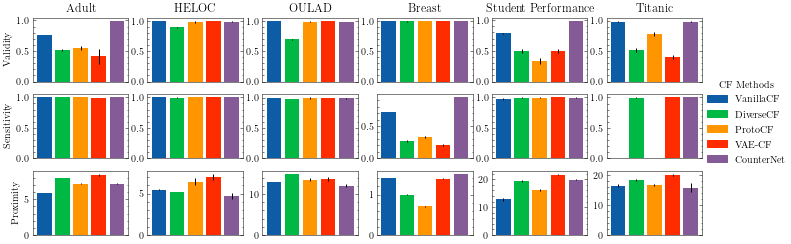

In [ ]:
fig = plot_error_bar()
fig.savefig('../results/error_bar.pdf')

# Evaluate Robustness

In [ ]:
configs = [
#     {
#         "name": "adult",
#         "baseline_path":
#         "../saved_weights/adult/baseline/epoch=55-step=10695.ckpt",
#         "baseline_iter": 56,
#         "c_net_path": "../saved_weights/adult/c_net/epoch=243-step=46603.ckpt",
#         "c_net_iter": 244
#     },
#     {
#         "name": "home",
#         "baseline_path":
#         "../saved_weights/home/baseline/epoch=92-step=5765.ckpt",
#         "baseline_iter": 93,
#         "c_net_path": "../saved_weights/home/c_net/epoch=993-step=61627.ckpt",
#         "c_net_iter": 994
#     },
#     {
#         "name": "student",
#         "baseline_path":
#         "../saved_weights/student/baseline/epoch=98-step=18908.ckpt",
#         "baseline_iter": 99,
#         "c_net_path": "../saved_weights/student/c_net/epoch=767-step=146687.ckpt",
#         "c_net_iter": 768
#     },
    {
        "name": "extra/student_performance",
        "baseline_path":
        "../saved_weights/extra/student_performance/baseline/epoch=287-step=1151.ckpt",
        "baseline_iter": 288,
        "c_net_path": "../saved_weights/extra/student_performance/c_net/epoch=142-step=571.ckpt",
        "c_net_iter": 143
    },
    {
        "name": "extra/titanic",
        "baseline_path":
        "../saved_weights/extra/titanic/baseline/epoch=63-step=383.ckpt",
        "baseline_iter": 64,
        "c_net_path": "../saved_weights/extra/titanic/c_net/epoch=26-step=161.ckpt",
        "c_net_iter": 27
    },
    {
        "name": "extra/breast",
        "baseline_path":
        "../saved_weights/extra/breast/baseline/epoch=383-step=1535.ckpt",
        "baseline_iter": 384,
        "c_net_path": "../saved_weights/extra/breast/c_net/epoch=371-step=1487.ckpt",
        "c_net_iter": 372
    },
    
]

In [ ]:
def evaluate_robustness(configs, thresholds: list):
    def calculate_robustness(cf_module: DataModule, cf_result: dict):
        diffs, total_nums = cf_module.check_cont_robustness(cf_result['x'], cf_result['cf'], cf_result['cf_y'])
        return {
            "diffs": diffs.item(),
            "total_nums": total_nums,
            "robustness": 1.0 - diffs.item() / total_nums
        }
    
    r = {}
    for config in configs:
        baseline = load_model(config['baseline_path'], config['baseline_iter'])
        c_net = load_model(config['c_net_path'], config['c_net_iter'], module=CounterfactualModel2Optimizers)
        r[config['name']] = {}
        for threshold in thresholds:
            baseline.threshold = threshold
            c_net.threshold = threshold
            
            vanilla_cf = torch.load(f"../results/{config['name']}/VanillaCF_result.pt")
            vanilla_robustness = calculate_robustness(baseline, vanilla_cf)
            
            diverse_cf = torch.load(f"../results/{config['name']}/DiverseCF_result.pt")
            diverse_robustness = calculate_robustness(baseline, diverse_cf)
            
            proto_cf = torch.load(f"../results/{config['name']}/ProtoCF_result.pt")
            proto_robustness = calculate_robustness(baseline, proto_cf)
            
            vae_cf = torch.load(f"../results/{config['name']}/VAE-CF_result.pt")
            vae_robustness = calculate_robustness(baseline, vae_cf)
            
            c_net_cf = torch.load(f"../results/{config['name']}/CounterfactualNet_result.pt")
            c_net_robustness = calculate_robustness(c_net, c_net_cf)
            
            r[config['name']][f"{threshold}"] = {
                "vanilla_cf": vanilla_robustness,
                "diverse_cf": diverse_robustness,
                "proto_cf": proto_robustness,
                "vae_cf": vae_robustness,
                "c_net_cf": c_net_robustness
            }
            
            csv_path = f"../results/{config['name']}/robustness/threshold={threshold}-result.csv"
            pd.DataFrame.from_dict(r[config['name']][f"{threshold}"], orient="index",).to_csv(csv_path)
    return r

In [ ]:
r = evaluate_robustness(configs, thresholds=[1.0, 2.0, 5.0, 10.0])

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 2.3 K  | [1, 29]  | [1, 1]   
------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 2.1 K  | [1, 29]  | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 2.1 K  | [1, 10]  | [1, 29]  
------------------------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 5.0 K  | [1, 35]  | [1, 1]   
------------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 4.8 K  | [1, 35]  | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 4.8 K  | [1, 10]  | [1, 35]  
------------------------------------------------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 14.2 K | [1, 127] | [1, 1]   
------------------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (32593, 23), x_cat: (32593, 104)
(32593, 127)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 14.0 K | [1, 127] | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 14.1 K | [1, 10]  | [1, 127] 
------------------------------------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

# Realism

## Train models

In [ ]:
dummy_config = load_json("../counterfactual/configs/dummy.json")
t_config = json.load(open("../counterfactual/configs/trainer.json"))

result = train(
    module=CounterfactualModel2Optimizers(dummy_config),
    t_configs=t_config,
    logger=pl_loggers.TestTubeLogger(Path('../log/'), name="dummy/cf_2opt")
)

counter_net = result['module']


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
hyper parameters: "batch_size":     128
"continous_cols": ['x1', 'x2', 'x3', 'x4']
"data_dir":       data/dummy_data.csv
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [4, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       1.0
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.0003
"threshold":      1.0
x_cont: (10000, 4), x_cat: (10000, 0)
(10000, 4)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 1.7 K  | [1, 4]   | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 174    | [1, 10]  | [1, 4]   
----------------------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]                       

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 0:  75%|███████▍  | 59/79 [00:01<00:00, 39.73it/s, loss=0.206, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 79/79 [00:01<00:00, 42.49it/s, loss=0.206, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 1:  76%|███████▌  | 60/79 [00:01<00:00, 39.61it/s, loss=0.165, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 42.00it/s, loss=0.165, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 2:  76%|███████▌  | 60/79 [00:01<00:00, 38.52it/s, loss=0.125, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 41.37it/s, loss=0.125, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 3:  76%|███████▌  | 60/79 [00:01<00:00, 38.87it/s, loss=0.0944, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 41.44it/s, loss=0.0944, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 4:  76%|███████▌  | 60/79 [00:01<00:00, 38.84it/s, loss=0.0785, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 41.61it/s, loss=0.0785, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 5:  76%|███████▌  | 60/79 [00:01<00:00, 38.35it/s, loss=0.0697, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 41.22it/s, loss=0.0697, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 6:  76%|███████▌  | 60/79 [00:01<00:00, 38.82it/s, loss=0.0687, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 41.40it/s, loss=0.0687, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 7:  76%|███████▌  | 60/79 [00:01<00:00, 37.52it/s, loss=0.0597, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 40.31it/s, loss=0.0597, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 8:  76%|███████▌  | 60/79 [00:01<00:00, 31.92it/s, loss=0.0557, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 35.51it/s, loss=0.0557, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 9:  76%|███████▌  | 60/79 [00:01<00:00, 39.04it/s, loss=0.0532, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 41.59it/s, loss=0.0532, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 10:  76%|███████▌  | 60/79 [00:01<00:00, 38.80it/s, loss=0.0511, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s, loss=0.0511, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 11:  76%|███████▌  | 60/79 [00:01<00:00, 38.38it/s, loss=0.0462, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 41.21it/s, loss=0.0462, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 12:  76%|███████▌  | 60/79 [00:01<00:00, 38.34it/s, loss=0.0463, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 41.31it/s, loss=0.0463, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 13:  76%|███████▌  | 60/79 [00:01<00:00, 38.79it/s, loss=0.0477, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 41.76it/s, loss=0.0477, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 14:  76%|███████▌  | 60/79 [00:01<00:00, 39.12it/s, loss=0.0503, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 41.73it/s, loss=0.0503, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 15:  76%|███████▌  | 60/79 [00:01<00:00, 38.51it/s, loss=0.0471, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s, loss=0.0471, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 16:  76%|███████▌  | 60/79 [00:01<00:00, 38.28it/s, loss=0.045, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 41.14it/s, loss=0.045, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 17:  76%|███████▌  | 60/79 [00:01<00:00, 38.48it/s, loss=0.0484, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 41.31it/s, loss=0.0484, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 18:  76%|███████▌  | 60/79 [00:01<00:00, 38.67it/s, loss=0.0463, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 41.26it/s, loss=0.0463, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 19:  76%|███████▌  | 60/79 [00:01<00:00, 38.20it/s, loss=0.0451, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 41.02it/s, loss=0.0451, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 20:  76%|███████▌  | 60/79 [00:01<00:00, 38.57it/s, loss=0.0461, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s, loss=0.0461, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 21:  76%|███████▌  | 60/79 [00:01<00:00, 38.74it/s, loss=0.0439, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s, loss=0.0439, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 22:  76%|███████▌  | 60/79 [00:01<00:00, 37.77it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 23:  76%|███████▌  | 60/79 [00:01<00:00, 38.58it/s, loss=0.0435, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████| 79/79 [00:01<00:00, 41.46it/s, loss=0.0435, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 24:  76%|███████▌  | 60/79 [00:01<00:00, 38.12it/s, loss=0.0465, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 79/79 [00:01<00:00, 40.60it/s, loss=0.0465, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 25:  76%|███████▌  | 60/79 [00:01<00:00, 38.66it/s, loss=0.0414, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 79/79 [00:01<00:00, 41.21it/s, loss=0.0414, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 26:  76%|███████▌  | 60/79 [00:01<00:00, 38.63it/s, loss=0.043, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s, loss=0.043, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 27:  76%|███████▌  | 60/79 [00:01<00:00, 37.68it/s, loss=0.0457, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 79/79 [00:01<00:00, 40.57it/s, loss=0.0457, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 28:  76%|███████▌  | 60/79 [00:01<00:00, 38.22it/s, loss=0.0464, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 79/79 [00:01<00:00, 40.95it/s, loss=0.0464, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 29:  76%|███████▌  | 60/79 [00:01<00:00, 38.78it/s, loss=0.0432, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 79/79 [00:01<00:00, 41.35it/s, loss=0.0432, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 30:  76%|███████▌  | 60/79 [00:01<00:00, 38.38it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 79/79 [00:01<00:00, 41.00it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 31:  76%|███████▌  | 60/79 [00:01<00:00, 38.82it/s, loss=0.0425, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 79/79 [00:01<00:00, 41.37it/s, loss=0.0425, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 32:  76%|███████▌  | 60/79 [00:01<00:00, 38.35it/s, loss=0.0407, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 79/79 [00:01<00:00, 40.96it/s, loss=0.0407, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 33:  76%|███████▌  | 60/79 [00:01<00:00, 38.07it/s, loss=0.0456, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████| 79/79 [00:01<00:00, 40.87it/s, loss=0.0456, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 34:  76%|███████▌  | 60/79 [00:01<00:00, 39.02it/s, loss=0.0408, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s, loss=0.0408, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 35:  76%|███████▌  | 60/79 [00:01<00:00, 38.96it/s, loss=0.0422, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 35: 100%|██████████| 79/79 [00:02<00:00, 37.41it/s, loss=0.0422, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 36:  76%|███████▌  | 60/79 [00:01<00:00, 38.91it/s, loss=0.0421, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████| 79/79 [00:01<00:00, 41.55it/s, loss=0.0421, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 37:  76%|███████▌  | 60/79 [00:01<00:00, 38.19it/s, loss=0.0429, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████| 79/79 [00:01<00:00, 40.74it/s, loss=0.0429, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 38:  76%|███████▌  | 60/79 [00:01<00:00, 38.12it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████| 79/79 [00:01<00:00, 40.80it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 39:  76%|███████▌  | 60/79 [00:01<00:00, 38.57it/s, loss=0.0442, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 79/79 [00:01<00:00, 40.95it/s, loss=0.0442, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 40:  76%|███████▌  | 60/79 [00:01<00:00, 38.21it/s, loss=0.0458, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████| 79/79 [00:01<00:00, 40.96it/s, loss=0.0458, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 41:  76%|███████▌  | 60/79 [00:01<00:00, 38.93it/s, loss=0.0397, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 41: 100%|██┈█㖀█████| 79/79 [00:01<00:00, 41.36it/s, loss=0.0397, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 42:  76%|███████▌  | 60/79 [00:01<00:00, 38.52it/s, loss=0.0442, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 42: 100%|██████████| 79/79 [00:01<00:00, 41.25it/s, loss=0.0442, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 43:  76%|███████▌  | 60/79 [00:01<00:00, 38.96it/s, loss=0.0449, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████| 79/79 [00:01<00:00, 41.75it/s, loss=0.0449, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 44:  76%|███████▌  | 60/79 [00:01<00:00, 37.05it/s, loss=0.0417, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 44: 100%|██████████| 79/79 [00:02<00:00, 39.48it/s, loss=0.0417, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 45:  76%|███████▌  | 60/79 [00:01<00:00, 37.65it/s, loss=0.0418, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████| 79/79 [00:01<00:00, 40.36it/s, loss=0.0418, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 46:  76%|███████▌  | 60/79 [00:01<00:00, 37.93it/s, loss=0.0437, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████| 79/79 [00:01<00:00, 40.40it/s, loss=0.0437, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 47:  76%|███████▌  | 60/79 [00:01<00:00, 36.89it/s, loss=0.0407, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 79/79 [00:01<00:00, 39.55it/s, loss=0.0407, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 48:  76%|███████▌  | 60/79 [00:01<00:00, 37.83it/s, loss=0.0454, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████| 79/79 [00:01<00:00, 40.28it/s, loss=0.0454, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 49:  76%|███████▌  | 60/79 [00:01<00:00, 36.25it/s, loss=0.041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 79/79 [00:02<00:00, 39.14it/s, loss=0.041, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 50:  76%|███████▌  | 60/79 [00:01<00:00, 38.53it/s, loss=0.0401, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 50: 100%|██████████| 79/79 [00:01<00:00, 41.21it/s, loss=0.0401, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 51:  76%|███████▌  | 60/79 [00:01<00:00, 38.61it/s, loss=0.042, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 51: 100%|██████████| 79/79 [00:01<00:00, 41.15it/s, loss=0.042, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 52:  76%|███████▌  | 60/79 [00:01<00:00, 37.34it/s, loss=0.0438, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 52: 100%|██████████| 79/79 [00:01<00:00, 40.07it/s, loss=0.0438, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 53:  76%|███████▌  | 60/79 [00:01<00:00, 38.08it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 53: 100%|██████████| 79/79 [00:01<00:00, 40.71it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 54:  76%|███████▌  | 60/79 [00:01<00:00, 32.60it/s, loss=0.0408, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 54:  91%|█████████ | 72/79 [00:02<00:00, 33.70it/s, loss=0.0408, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 55:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0408, v_num=4]         

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 55:  76%|███████▌  | 60/79 [00:01<00:00, 35.43it/s, loss=0.0442, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 55: 100%|██████████| 79/79 [00:02<00:00, 38.55it/s, loss=0.0442, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 56:  76%|███████▌  | 60/79 [00:01<00:00, 37.62it/s, loss=0.0402, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 56: 100%|██████████| 79/79 [00:01<00:00, 40.23it/s, loss=0.0402, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 57:  76%|███████▌  | 60/79 [00:01<00:00, 36.64it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 57: 100%|██████████| 79/79 [00:02<00:00, 39.24it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 58:  76%|███████▌  | 60/79 [00:01<00:00, 36.59it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 58: 100%|██████████| 79/79 [00:02<00:00, 39.33it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 59:  76%|███████▌  | 60/79 [00:01<00:00, 36.33it/s, loss=0.0398, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 79/79 [00:02<00:00, 39.03it/s, loss=0.0398, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 60:  76%|███████▌  | 60/79 [00:01<00:00, 37.42it/s, loss=0.0385, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 60: 100%|██████████| 79/79 [00:01<00:00, 40.01it/s, loss=0.0385, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 61:  76%|███████▌  | 60/79 [00:01<00:00, 35.84it/s, loss=0.0445, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 61: 100%|██████████| 79/79 [00:02<00:00, 38.64it/s, loss=0.0445, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 62:  76%|███████▌  | 60/79 [00:01<00:00, 36.12it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 62: 100%|██████████| 79/79 [00:02<00:00, 38.57it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 63:  76%|███████▌  | 60/79 [00:01<00:00, 35.50it/s, loss=0.0414, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 63: 100%|██████████| 79/79 [00:02<00:00, 38.38it/s, loss=0.0414, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 64:  76%|███████▌  | 60/79 [00:01<00:00, 30.82it/s, loss=0.0355, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 64: 100%|██████████| 79/79 [00:02<00:00, 34.04it/s, loss=0.0355, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 65:  76%|███████▌  | 60/79 [00:02<00:00, 29.14it/s, loss=0.0402, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 65: 100%|██████████| 79/79 [00:02<00:00, 32.60it/s, loss=0.0402, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 66:  76%|███████▌  | 60/79 [00:01<00:00, 33.82it/s, loss=0.0389, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 66: 100%|██████████| 79/79 [00:02<00:00, 36.59it/s, loss=0.0389, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 67:  76%|███████▌  | 60/79 [00:01<00:00, 35.46it/s, loss=0.0384, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 67: 100%|██████████| 79/79 [00:02<00:00, 38.14it/s, loss=0.0384, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 68:  76%|███████▌  | 60/79 [00:01<00:00, 35.83it/s, loss=0.0412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 68: 100%|██████████| 79/79 [00:02<00:00, 38.52it/s, loss=0.0412, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 69:  76%|███████▌  | 60/79 [00:01<00:00, 34.20it/s, loss=0.0437, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 69: 100%|██████████| 79/79 [00:02<00:00, 36.54it/s, loss=0.0437, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 70:  76%|███████▌  | 60/79 [00:01<00:00, 32.86it/s, loss=0.0419, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 70: 100%|██████████| 79/79 [00:02<00:00, 35.58it/s, loss=0.0419, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 71:  76%|███████▌  | 60/79 [00:01<00:00, 34.11it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 71: 100%|██████████| 79/79 [00:02<00:00, 36.83it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 72:  76%|███████▌  | 60/79 [00:01<00:00, 32.86it/s, loss=0.0431, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 72: 100%|██████████| 79/79 [00:02<00:00, 35.66it/s, loss=0.0431, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 73:  76%|███████▌  | 60/79 [00:01<00:00, 33.02it/s, loss=0.0411, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 73: 100%|██████████| 79/79 [00:02<00:00, 35.50it/s, loss=0.0411, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 74:  76%|███████▌  | 60/79 [00:01<00:00, 32.82it/s, loss=0.042, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 74: 100%|██████████| 79/79 [00:02<00:00, 35.62it/s, loss=0.042, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 75:  76%|███████▌  | 60/79 [00:01<00:00, 33.46it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 75:  91%|█████████ | 72/79 [00:02<00:00, 34.23it/s, loss=0.0415, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 76:  76%|███████▌  | 60/79 [00:01<00:00, 33.24it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 76: 100%|██████████| 79/79 [00:02<00:00, 36.05it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 77:  76%|███████▌  | 60/79 [00:01<00:00, 33.44it/s, loss=0.0383, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 77: 100%|██████████| 79/79 [00:02<00:00, 36.21it/s, loss=0.0383, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 78:  76%|███████▌  | 60/79 [00:01<00:00, 34.16it/s, loss=0.0402, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 78:  91%|█████████ | 72/79 [00:02<00:00, 34.84it/s, loss=0.0402, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 79:  76%|███████▌  | 60/79 [00:01<00:00, 32.35it/s, loss=0.0435, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 79:  91%|█████████ | 72/79 [00:02<00:00, 33.15it/s, loss=0.0435, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 80:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0435, v_num=4]         

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 80:  76%|███████▌  | 60/79 [00:01<00:00, 31.93it/s, loss=0.0421, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 80:  91%|█████████ | 72/79 [00:02<00:00, 32.80it/s, loss=0.0421, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 81:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0421, v_num=4]         

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 81:  76%|███████▌  | 60/79 [00:01<00:00, 32.48it/s, loss=0.042, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 81:  91%|█████████ | 72/79 [00:02<00:00, 33.60it/s, loss=0.042, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 82:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.042, v_num=4]         

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 82:  76%|███████▌  | 60/79 [00:01<00:00, 32.83it/s, loss=0.0407, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 82: 100%|██████████| 79/79 [00:02<00:00, 35.42it/s, loss=0.0407, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 83:  76%|███████▌  | 60/79 [00:01<00:00, 32.09it/s, loss=0.0402, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 83:  91%|█████████ | 72/79 [00:02<00:00, 33.22it/s, loss=0.0402, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 84:  76%|███████▌  | 60/79 [00:01<00:00, 33.35it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 84: 100%|██████████| 79/79 [00:02<00:00, 36.08it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 85:  76%|███████▌  | 60/79 [00:01<00:00, 33.48it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 85: 100%|██████████| 79/79 [00:02<00:00, 36.00it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 86:  76%|███████▌  | 60/79 [00:01<00:00, 33.42it/s, loss=0.0446, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 86:  91%|█████████ | 72/79 [00:02<00:00, 34.61it/s, loss=0.0446, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 87:  76%|███████▌  | 60/79 [00:01<00:00, 34.17it/s, loss=0.0394, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 87:  91%|█████████ | 72/79 [00:02<00:00, 34.90it/s, loss=0.0394, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 88:  76%|███████▌  | 60/79 [00:01<00:00, 32.89it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 88: 100%|██████████| 79/79 [00:02<00:00, 35.58it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 89:  76%|███████▌  | 60/79 [00:01<00:00, 33.03it/s, loss=0.0446, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 89:  91%|█████████ | 72/79 [00:02<00:00, 34.18it/s, loss=0.0446, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 90:  76%|███████▌  | 60/79 [00:01<00:00, 33.56it/s, loss=0.0358, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 90: 100%|██████████| 79/79 [00:02<00:00, 36.17it/s, loss=0.0358, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 91:  76%|███████▌  | 60/79 [00:01<00:00, 34.25it/s, loss=0.0374, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 91:  91%|█████████ | 72/79 [00:02<00:00, 35.03it/s, loss=0.0374, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 92:  76%|███████▌  | 60/79 [00:01<00:00, 34.59it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 92: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 93:  76%|███████▌  | 60/79 [00:01<00:00, 34.81it/s, loss=0.0412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 93: 100%|██████████| 79/79 [00:02<00:00, 37.35it/s, loss=0.0412, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 94:  76%|███████▌  | 60/79 [00:01<00:00, 33.96it/s, loss=0.0376, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 94: 100%|██████████| 79/79 [00:02<00:00, 36.62it/s, loss=0.0376, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 95:  76%|███████▌  | 60/79 [00:01<00:00, 32.42it/s, loss=0.0429, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████| 79/79 [00:02<00:00, 35.46it/s, loss=0.0429, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 96:  76%|███████▌  | 60/79 [00:01<00:00, 34.52it/s, loss=0.0413, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████| 79/79 [00:02<00:00, 37.03it/s, loss=0.0413, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 97:  76%|███████▌  | 60/79 [00:01<00:00, 34.56it/s, loss=0.0384, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s, loss=0.0384, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 98:  76%|███████▌  | 60/79 [00:01<00:00, 33.70it/s, loss=0.0424, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 98: 100%|██████████| 79/79 [00:02<00:00, 36.42it/s, loss=0.0424, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 99:  76%|███████▌  | 60/79 [00:01<00:00, 32.99it/s, loss=0.0436, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 99:  91%|█████████ | 72/79 [00:02<00:00, 33.97it/s, loss=0.0436, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 100:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0436, v_num=4]        

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 100:  76%|███████▌  | 60/79 [00:01<00:00, 35.59it/s, loss=0.0418, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 100: 100%|██████████| 79/79 [00:02<00:00, 38.40it/s, loss=0.0418, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 101:  76%|███████▌  | 60/79 [00:01<00:00, 34.98it/s, loss=0.0403, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 101: 100%|██████████| 79/79 [00:02<00:00, 37.35it/s, loss=0.0403, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 102:  76%|███████▌  | 60/79 [00:01<00:00, 35.88it/s, loss=0.0377, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 102: 100%|██████████| 79/79 [00:02<00:00, 38.18it/s, loss=0.0377, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 103:  76%|███████▌  | 60/79 [00:01<00:00, 34.24it/s, loss=0.0358, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 103: 100%|██████████| 79/79 [00:02<00:00, 36.83it/s, loss=0.0358, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 104:  76%|███████▌  | 60/79 [00:01<00:00, 35.47it/s, loss=0.0394, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 104: 100%|██████████| 79/79 [00:02<00:00, 38.18it/s, loss=0.0394, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 105:  76%|███████▌  | 60/79 [00:01<00:00, 33.75it/s, loss=0.0408, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 105: 100%|██████████| 79/79 [00:02<00:00, 36.63it/s, loss=0.0408, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 106:  76%|███████▌  | 60/79 [00:01<00:00, 34.98it/s, loss=0.039, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 106: 100%|██████████| 79/79 [00:02<00:00, 37.72it/s, loss=0.039, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 107:  76%|███████▌  | 60/79 [00:01<00:00, 36.23it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 107: 100%|██████████| 79/79 [00:02<00:00, 38.69it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 108:  76%|███████▌  | 60/79 [00:01<00:00, 34.04it/s, loss=0.0388, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 108:  91%|█████████ | 72/79 [00:02<00:00, 34.86it/s, loss=0.0388, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 109:  76%|███████▌  | 60/79 [00:01<00:00, 34.02it/s, loss=0.036, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 109: 100%|██████████| 79/79 [00:02<00:00, 36.71it/s, loss=0.036, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 110:  76%|███████▌  | 60/79 [00:01<00:00, 34.46it/s, loss=0.0396, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 110: 100%|██████████| 79/79 [00:02<00:00, 37.29it/s, loss=0.0396, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 111:  76%|███████▌  | 60/79 [00:01<00:00, 34.31it/s, loss=0.0384, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 111: 100%|██████████| 79/79 [00:02<00:00, 36.98it/s, loss=0.0384, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 112:  76%|███████▌  | 60/79 [00:01<00:00, 35.17it/s, loss=0.0407, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 112: 100%|██████████| 79/79 [00:02<00:00, 38.01it/s, loss=0.0407, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 113:  76%|███████▌  | 60/79 [00:01<00:00, 35.59it/s, loss=0.0419, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 113: 100%|██████████| 79/79 [00:02<00:00, 38.07it/s, loss=0.0419, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 114:  76%|███████▌  | 60/79 [00:01<00:00, 35.20it/s, loss=0.0419, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 114: 100%|██████████| 79/79 [00:02<00:00, 38.00it/s, loss=0.0419, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 115:  76%|███████▌  | 60/79 [00:01<00:00, 35.31it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████| 79/79 [00:02<00:00, 38.04it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 116:  76%|███████▌  | 60/79 [00:01<00:00, 33.97it/s, loss=0.0427, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████| 79/79 [00:02<00:00, 36.88it/s, loss=0.0427, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 117:  76%|███████▌  | 60/79 [00:01<00:00, 34.82it/s, loss=0.0412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 117: 100%|██████████| 79/79 [00:02<00:00, 37.11it/s, loss=0.0412, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 118:  76%|███████▌  | 60/79 [00:01<00:00, 32.67it/s, loss=0.0413, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 118: 100%|██████████| 79/79 [00:02<00:00, 35.54it/s, loss=0.0413, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 119:  76%|███████▌  | 60/79 [00:01<00:00, 34.47it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 119: 100%|██████████| 79/79 [00:02<00:00, 37.33it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 120:  76%|███████▌  | 60/79 [00:01<00:00, 34.13it/s, loss=0.0381, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 120: 100%|██████████| 79/79 [00:02<00:00, 36.72it/s, loss=0.0381, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 121:  76%|███████▌  | 60/79 [00:01<00:00, 34.13it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 121: 100%|██████████| 79/79 [00:02<00:00, 36.69it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 122:  76%|███████▌  | 60/79 [00:01<00:00, 33.81it/s, loss=0.0386, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 122: 100%|██████████| 79/79 [00:02<00:00, 36.48it/s, loss=0.0386, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 123:  76%|███████▌  | 60/79 [00:01<00:00, 31.99it/s, loss=0.0438, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 123: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s, loss=0.0438, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 124:  76%|███████▌  | 60/79 [00:01<00:00, 35.61it/s, loss=0.0405, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 124: 100%|██████████| 79/79 [00:02<00:00, 38.19it/s, loss=0.0405, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 125:  76%|███████▌  | 60/79 [00:01<00:00, 36.18it/s, loss=0.041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 125: 100%|██████████| 79/79 [00:02<00:00, 38.92it/s, loss=0.041, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 126:  76%|███████▌  | 60/79 [00:01<00:00, 35.94it/s, loss=0.0422, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 126: 100%|██████████| 79/79 [00:02<00:00, 38.60it/s, loss=0.0422, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 127:  76%|███████▌  | 60/79 [00:01<00:00, 35.11it/s, loss=0.0431, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 127: 100%|██████████| 79/79 [00:02<00:00, 37.77it/s, loss=0.0431, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 128:  76%|███████▌  | 60/79 [00:01<00:00, 36.58it/s, loss=0.0423, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 128: 100%|██████████| 79/79 [00:02<00:00, 39.06it/s, loss=0.0423, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 129:  76%|███████▌  | 60/79 [00:01<00:00, 35.23it/s, loss=0.0421, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 129: 100%|██████████| 79/79 [00:02<00:00, 38.17it/s, loss=0.0421, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 130:  76%|███████▌  | 60/79 [00:01<00:00, 35.88it/s, loss=0.0427, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 130: 100%|██████████| 79/79 [00:02<00:00, 38.67it/s, loss=0.0427, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 131:  76%|███████▌  | 60/79 [00:01<00:00, 35.70it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 131: 100%|██████████| 79/79 [00:02<00:00, 38.20it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 132:  76%|███████▌  | 60/79 [00:01<00:00, 34.49it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 132: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 133:  76%|███████▌  | 60/79 [00:01<00:00, 34.57it/s, loss=0.0417, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 133: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s, loss=0.0417, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 134:  76%|███████▌  | 60/79 [00:01<00:00, 34.74it/s, loss=0.037, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 134: 100%|██████████| 79/79 [00:02<00:00, 37.66it/s, loss=0.037, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 135:  76%|███████▌  | 60/79 [00:01<00:00, 36.70it/s, loss=0.0404, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████| 79/79 [00:01<00:00, 39.50it/s, loss=0.0404, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 136:  76%|███████▌  | 60/79 [00:01<00:00, 36.73it/s, loss=0.0404, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 136: 100%|██████████| 79/79 [00:02<00:00, 39.04it/s, loss=0.0404, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 137:  76%|███████▌  | 60/79 [00:01<00:00, 37.12it/s, loss=0.0429, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████| 79/79 [00:01<00:00, 39.84it/s, loss=0.0429, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 138:  76%|███████▌  | 60/79 [00:01<00:00, 35.15it/s, loss=0.0423, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 138: 100%|██████████| 79/79 [00:02<00:00, 38.19it/s, loss=0.0423, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 139:  76%|███████▌  | 60/79 [00:01<00:00, 37.08it/s, loss=0.0414, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 139: 100%|██████████| 79/79 [00:01<00:00, 39.93it/s, loss=0.0414, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 140:  76%|███████▌  | 60/79 [00:01<00:00, 36.88it/s, loss=0.0386, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 140: 100%|██████████| 79/79 [00:01<00:00, 39.71it/s, loss=0.0386, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 141:  76%|███████▌  | 60/79 [00:01<00:00, 37.13it/s, loss=0.0394, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 141: 100%|██████████| 79/79 [00:01<00:00, 39.70it/s, loss=0.0394, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 142:  76%|███████▌  | 60/79 [00:01<00:00, 36.32it/s, loss=0.04, v_num=4]  
Validating: 0it [00:00, ?it/s]
Epoch 142: 100%|██████████| 79/79 [00:02<00:00, 39.30it/s, loss=0.04, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 143:  76%|███████▌  | 60/79 [00:01<00:00, 37.16it/s, loss=0.0386, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 143: 100%|██████████| 79/79 [00:02<00:00, 39.48it/s, loss=0.0386, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 144:  76%|███████▌  | 60/79 [00:01<00:00, 35.94it/s, loss=0.0406, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 144: 100%|██████████| 79/79 [00:02<00:00, 38.70it/s, loss=0.0406, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 145:  76%|███████▌  | 60/79 [00:01<00:00, 36.81it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 145: 100%|██████████| 79/79 [00:02<00:00, 39.43it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 146:  76%|███████▌  | 60/79 [00:01<00:00, 37.27it/s, loss=0.0393, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████| 79/79 [00:01<00:00, 40.07it/s, loss=0.0393, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 147:  76%|███████▌  | 60/79 [00:01<00:00, 37.26it/s, loss=0.041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 147: 100%|██████████| 79/79 [00:01<00:00, 39.97it/s, loss=0.041, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 148:  76%|███████▌  | 60/79 [00:01<00:00, 37.23it/s, loss=0.042, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 148: 100%|██████████| 79/79 [00:01<00:00, 39.79it/s, loss=0.042, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 149:  76%|███████▌  | 60/79 [00:01<00:00, 37.06it/s, loss=0.046, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 149: 100%|██████████| 79/79 [00:01<00:00, 39.63it/s, loss=0.046, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 150:  76%|███████▌  | 60/79 [00:01<00:00, 37.72it/s, loss=0.0384, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 150: 100%|██████████| 79/79 [00:01<00:00, 40.78it/s, loss=0.0384, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 151:  76%|███████▌  | 60/79 [00:01<00:00, 37.84it/s, loss=0.04, v_num=4]  
Validating: 0it [00:00, ?it/s]
Validating:  45%|████▌     | 9/20 [00:00<00:00, 18.25it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 151: 100%|██████████| 79/79 [00:02<00:00, 34.26it/s, loss=0.04, v_num=4]
                                                          

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 152:  76%|███████▌  | 60/79 [00:01<00:00, 38.30it/s, loss=0.0424, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 152: 100%|██████████| 79/79 [00:01<00:00, 41.08it/s, loss=0.0424, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 153:  76%|███████▌  | 60/79 [00:01<00:00, 38.47it/s, loss=0.0423, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 153: 100%|██████████| 79/79 [00:01<00:00, 41.31it/s, loss=0.0423, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 154:  76%|███████▌  | 60/79 [00:01<00:00, 38.62it/s, loss=0.0398, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 154: 100%|██████████| 79/79 [00:01<00:00, 41.41it/s, loss=0.0398, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 155:  76%|███████▌  | 60/79 [00:01<00:00, 37.02it/s, loss=0.0456, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 155: 100%|██████████| 79/79 [00:01<00:00, 39.95it/s, loss=0.0456, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 156:  76%|███████▌  | 60/79 [00:01<00:00, 38.52it/s, loss=0.0461, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 156: 100%|██████████| 79/79 [00:01<00:00, 41.04it/s, loss=0.0461, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 157:  76%|███████▌  | 60/79 [00:01<00:00, 37.49it/s, loss=0.0397, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 157: 100%|██████████| 79/79 [00:01<00:00, 40.45it/s, loss=0.0397, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 158:  76%|███████▌  | 60/79 [00:01<00:00, 38.15it/s, loss=0.0421, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 158: 100%|██████████| 79/79 [00:01<00:00, 40.81it/s, loss=0.0421, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 159:  76%|███████▌  | 60/79 [00:01<00:00, 37.50it/s, loss=0.0378, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 159: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s, loss=0.0378, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 160:  76%|███████▌  | 60/79 [00:01<00:00, 38.06it/s, loss=0.0451, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 160: 100%|██████████| 79/79 [00:01<00:00, 40.83it/s, loss=0.0451, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 161:  76%|███████▌  | 60/79 [00:01<00:00, 37.02it/s, loss=0.0398, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 161: 100%|██████████| 79/79 [00:01<00:00, 40.03it/s, loss=0.0398, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 162:  76%|███████▌  | 60/79 [00:01<00:00, 38.15it/s, loss=0.0411, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 162: 100%|██████████| 79/79 [00:01<00:00, 40.90it/s, loss=0.0411, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 163:  76%|███████▌  | 60/79 [00:01<00:00, 38.37it/s, loss=0.0398, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 163: 100%|██████████| 79/79 [00:01<00:00, 41.12it/s, loss=0.0398, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 164:  76%|███████▌  | 60/79 [00:01<00:00, 37.61it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 164: 100%|██████████| 79/79 [00:01<00:00, 40.61it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 165:  76%|███████▌  | 60/79 [00:01<00:00, 37.89it/s, loss=0.04, v_num=4]  
Validating: 0it [00:00, ?it/s]
Epoch 165: 100%|██████████| 79/79 [00:01<00:00, 40.76it/s, loss=0.04, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 166:  76%|███████▌  | 60/79 [00:01<00:00, 37.15it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 166: 100%|██████████| 79/79 [00:01<00:00, 40.06it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 167:  76%|███████▌  | 60/79 [00:01<00:00, 37.66it/s, loss=0.0375, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 167: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s, loss=0.0375, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 168:  76%|███████▌  | 60/79 [00:01<00:00, 38.18it/s, loss=0.0428, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 168: 100%|██████████| 79/79 [00:01<00:00, 40.81it/s, loss=0.0428, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 169:  76%|███████▌  | 60/79 [00:01<00:00, 37.70it/s, loss=0.0457, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 169: 100%|██████████| 79/79 [00:01<00:00, 40.19it/s, loss=0.0457, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 170:  76%|███████▌  | 60/79 [00:01<00:00, 37.81it/s, loss=0.0403, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 170: 100%|██████████| 79/79 [00:01<00:00, 40.54it/s, loss=0.0403, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 171:  76%|███████▌  | 60/79 [00:01<00:00, 37.46it/s, loss=0.0436, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 171: 100%|██████████| 79/79 [00:01<00:00, 40.48it/s, loss=0.0436, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 172:  76%|███████▌  | 60/79 [00:01<00:00, 35.95it/s, loss=0.0431, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 172: 100%|██████████| 79/79 [00:02<00:00, 38.98it/s, loss=0.0431, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 173:  76%|███████▌  | 60/79 [00:01<00:00, 38.34it/s, loss=0.0411, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 173: 100%|██████████| 79/79 [00:01<00:00, 40.74it/s, loss=0.0411, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 174:  76%|███████▌  | 60/79 [00:01<00:00, 37.90it/s, loss=0.0439, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 174: 100%|██████████| 79/79 [00:01<00:00, 40.77it/s, loss=0.0439, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 175:  76%|███████▌  | 60/79 [00:01<00:00, 38.02it/s, loss=0.0433, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 175: 100%|██████████| 79/79 [00:01<00:00, 40.87it/s, loss=0.0433, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 176:  76%|███████▌  | 60/79 [00:01<00:00, 37.55it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 176: 100%|██████████| 79/79 [00:01<00:00, 40.43it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 177:  76%|███████▌  | 60/79 [00:01<00:00, 36.73it/s, loss=0.0436, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 177: 100%|██████████| 79/79 [00:01<00:00, 39.73it/s, loss=0.0436, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 178:  76%|███████▌  | 60/79 [00:01<00:00, 38.40it/s, loss=0.0427, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 178: 100%|██████████| 79/79 [00:01<00:00, 41.31it/s, loss=0.0427, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 179:  76%|███████▌  | 60/79 [00:01<00:00, 37.58it/s, loss=0.0414, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 179: 100%|██████████| 79/79 [00:01<00:00, 40.46it/s, loss=0.0414, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 180:  76%|███████▌  | 60/79 [00:01<00:00, 38.07it/s, loss=0.0405, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 180: 100%|██████████| 79/79 [00:01<00:00, 40.87it/s, loss=0.0405, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 181:  76%|███████▌  | 60/79 [00:01<00:00, 37.31it/s, loss=0.0439, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 181: 100%|██████████| 79/79 [00:01<00:00, 39.99it/s, loss=0.0439, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 182:  76%|███████▌  | 60/79 [00:01<00:00, 38.47it/s, loss=0.0425, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 182: 100%|██████████| 79/79 [00:01<00:00, 41.47it/s, loss=0.0425, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 183:  76%|███████▌  | 60/79 [00:01<00:00, 36.58it/s, loss=0.0447, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 183: 100%|██████████| 79/79 [00:01<00:00, 39.86it/s, loss=0.0447, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 184:  76%|███████▌  | 60/79 [00:01<00:00, 37.58it/s, loss=0.0412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 184: 100%|██████████| 79/79 [00:01<00:00, 40.43it/s, loss=0.0412, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 185:  76%|███████▌  | 60/79 [00:01<00:00, 38.45it/s, loss=0.0438, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 185: 100%|██████████| 79/79 [00:01<00:00, 41.10it/s, loss=0.0438, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 186:  76%|███████▌  | 60/79 [00:01<00:00, 37.78it/s, loss=0.0403, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 186: 100%|██████████| 79/79 [00:01<00:00, 40.79it/s, loss=0.0403, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 187:  76%|███████▌  | 60/79 [00:01<00:00, 37.02it/s, loss=0.04, v_num=4]  
Validating: 0it [00:00, ?it/s]
Epoch 187: 100%|██████████| 79/79 [00:01<00:00, 39.78it/s, loss=0.04, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 188:  76%|███████▌  | 60/79 [00:01<00:00, 35.46it/s, loss=0.0404, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 188: 100%|██████████| 79/79 [00:02<00:00, 38.34it/s, loss=0.0404, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 189:  76%|███████▌  | 60/79 [00:01<00:00, 36.89it/s, loss=0.0448, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 189: 100%|██████████| 79/79 [00:01<00:00, 39.82it/s, loss=0.0448, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 190:  76%|███████▌  | 60/79 [00:01<00:00, 37.75it/s, loss=0.0425, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 190: 100%|██████████| 79/79 [00:01<00:00, 40.61it/s, loss=0.0425, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 191:  76%|███████▌  | 60/79 [00:01<00:00, 37.17it/s, loss=0.0448, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 191: 100%|██████████| 79/79 [00:01<00:00, 39.73it/s, loss=0.0448, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 192:  76%|███████▌  | 60/79 [00:01<00:00, 38.47it/s, loss=0.0437, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 192: 100%|██████████| 79/79 [00:01<00:00, 41.01it/s, loss=0.0437, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 193:  76%|███████▌  | 60/79 [00:01<00:00, 37.77it/s, loss=0.0414, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 193: 100%|██████████| 79/79 [00:01<00:00, 40.32it/s, loss=0.0414, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 194:  76%|███████▌  | 60/79 [00:01<00:00, 36.31it/s, loss=0.0422, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 194: 100%|██████████| 79/79 [00:02<00:00, 39.36it/s, loss=0.0422, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 195:  76%|███████▌  | 60/79 [00:01<00:00, 38.15it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 195: 100%|██████████| 79/79 [00:01<00:00, 40.82it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 196:  76%|███████▌  | 60/79 [00:01<00:00, 38.21it/s, loss=0.0457, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 196: 100%|██████████| 79/79 [00:01<00:00, 40.79it/s, loss=0.0457, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 197:  76%|███████▌  | 60/79 [00:01<00:00, 38.38it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 197: 100%|██████████| 79/79 [00:01<00:00, 41.18it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 198:  76%|███████▌  | 60/79 [00:01<00:00, 37.66it/s, loss=0.0428, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 198: 100%|██████████| 79/79 [00:01<00:00, 40.45it/s, loss=0.0428, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 199:  76%|███████▌  | 60/79 [00:01<00:00, 37.65it/s, loss=0.0426, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 79/79 [00:01<00:00, 40.39it/s, loss=0.0426, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 200:  76%|███████▌  | 60/79 [00:01<00:00, 38.19it/s, loss=0.0436, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 200: 100%|██████████| 79/79 [00:01<00:00, 41.16it/s, loss=0.0436, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 201:  76%|███████▌  | 60/79 [00:01<00:00, 37.94it/s, loss=0.0424, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 201: 100%|██████████| 79/79 [00:01<00:00, 40.62it/s, loss=0.0424, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 202:  76%|███████▌  | 60/79 [00:01<00:00, 38.32it/s, loss=0.0418, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 202: 100%|██████████| 79/79 [00:01<00:00, 40.94it/s, loss=0.0418, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 203:  76%|███████▌  | 60/79 [00:01<00:00, 37.58it/s, loss=0.0391, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 203: 100%|██████████| 79/79 [00:01<00:00, 40.50it/s, loss=0.0391, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 204:  76%|███████▌  | 60/79 [00:01<00:00, 37.48it/s, loss=0.045, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 204: 100%|██████████| 79/79 [00:01<00:00, 40.18it/s, loss=0.045, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 205:  76%|███████▌  | 60/79 [00:01<00:00, 36.65it/s, loss=0.0421, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 205: 100%|██████████| 79/79 [00:01<00:00, 39.64it/s, loss=0.0421, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 206:  76%|███████▌  | 60/79 [00:01<00:00, 37.18it/s, loss=0.0412, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 206: 100%|██████████| 79/79 [00:01<00:00, 40.15it/s, loss=0.0412, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 207:  76%|███████▌  | 60/79 [00:01<00:00, 38.15it/s, loss=0.0456, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 207: 100%|██████████| 79/79 [00:01<00:00, 40.82it/s, loss=0.0456, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 208:  76%|███████▌  | 60/79 [00:01<00:00, 37.16it/s, loss=0.0417, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 208: 100%|██████████| 79/79 [00:01<00:00, 39.91it/s, loss=0.0417, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 209:  76%|███████▌  | 60/79 [00:01<00:00, 38.39it/s, loss=0.0442, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 209: 100%|██████████| 79/79 [00:01<00:00, 40.97it/s, loss=0.0442, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 210:  76%|███████▌  | 60/79 [00:01<00:00, 37.18it/s, loss=0.0413, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 210: 100%|██████████| 79/79 [00:01<00:00, 40.06it/s, loss=0.0413, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 211:  76%|███████▌  | 60/79 [00:01<00:00, 36.90it/s, loss=0.0387, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 211: 100%|██████████| 79/79 [00:01<00:00, 39.88it/s, loss=0.0387, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 212:  76%|███████▌  | 60/79 [00:01<00:00, 38.04it/s, loss=0.0461, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 212: 100%|██████████| 79/79 [00:01<00:00, 40.56it/s, loss=0.0461, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 213:  76%|███████▌  | 60/79 [00:01<00:00, 37.54it/s, loss=0.0393, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 213: 100%|██████████| 79/79 [00:01<00:00, 40.34it/s, loss=0.0393, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 214:  76%|███████▌  | 60/79 [00:01<00:00, 38.07it/s, loss=0.0402, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 214: 100%|██████████| 79/79 [00:01<00:00, 40.96it/s, loss=0.0402, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 215:  76%|███████▌  | 60/79 [00:01<00:00, 37.24it/s, loss=0.0432, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 215: 100%|██████████| 79/79 [00:01<00:00, 39.72it/s, loss=0.0432, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 216:  76%|███████▌  | 60/79 [00:01<00:00, 36.13it/s, loss=0.0428, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 216: 100%|██████████| 79/79 [00:02<00:00, 39.18it/s, loss=0.0428, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 217:  76%|███████▌  | 60/79 [00:01<00:00, 33.45it/s, loss=0.0449, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 217: 100%|██████████| 79/79 [00:02<00:00, 36.67it/s, loss=0.0449, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 218:  76%|███████▌  | 60/79 [00:01<00:00, 37.45it/s, loss=0.044, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 218: 100%|██████████| 79/79 [00:01<00:00, 40.42it/s, loss=0.044, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 219:  76%|███████▌  | 60/79 [00:01<00:00, 38.50it/s, loss=0.0416, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 219: 100%|██████████| 79/79 [00:01<00:00, 41.09it/s, loss=0.0416, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 220:  76%|███████▌  | 60/79 [00:01<00:00, 38.21it/s, loss=0.0424, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 220: 100%|██████████| 79/79 [00:01<00:00, 40.96it/s, loss=0.0424, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 221:  76%|███████▌  | 60/79 [00:01<00:00, 37.88it/s, loss=0.0464, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 221: 100%|██████████| 79/79 [00:01<00:00, 40.49it/s, loss=0.0464, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 222:  76%|███████▌  | 60/79 [00:01<00:00, 35.70it/s, loss=0.0409, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 222: 100%|██████████| 79/79 [00:02<00:00, 38.83it/s, loss=0.0409, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 223:  76%|███████▌  | 60/79 [00:01<00:00, 36.79it/s, loss=0.0423, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 223: 100%|██████████| 79/79 [00:01<00:00, 39.83it/s, loss=0.0423, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 224:  76%|███████▌  | 60/79 [00:01<00:00, 37.95it/s, loss=0.0399, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 224: 100%|██████████| 79/79 [00:01<00:00, 40.58it/s, loss=0.0399, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 225:  76%|███████▌  | 60/79 [00:01<00:00, 37.76it/s, loss=0.0425, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 225: 100%|██████████| 79/79 [00:01<00:00, 40.38it/s, loss=0.0425, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 226:  76%|███████▌  | 60/79 [00:01<00:00, 37.80it/s, loss=0.0426, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 226: 100%|██████████| 79/79 [00:01<00:00, 40.64it/s, loss=0.0426, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 227:  76%|███████▌  | 60/79 [00:01<00:00, 35.61it/s, loss=0.048, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 227: 100%|██████████| 79/79 [00:02<00:00, 38.60it/s, loss=0.048, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 228:  76%|███████▌  | 60/79 [00:01<00:00, 36.70it/s, loss=0.0456, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 228: 100%|██████████| 79/79 [00:01<00:00, 39.52it/s, loss=0.0456, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 229:  76%|███████▌  | 60/79 [00:01<00:00, 36.89it/s, loss=0.0455, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 229: 100%|██████████| 79/79 [00:01<00:00, 39.58it/s, loss=0.0455, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 230:  76%|███████▌  | 60/79 [00:01<00:00, 36.85it/s, loss=0.041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 230: 100%|██████████| 79/79 [00:02<00:00, 39.46it/s, loss=0.041, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 231:  76%|███████▌  | 60/79 [00:01<00:00, 37.60it/s, loss=0.0468, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 231: 100%|██████████| 79/79 [00:01<00:00, 39.99it/s, loss=0.0468, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 232:  76%|███████▌  | 60/79 [00:01<00:00, 34.74it/s, loss=0.0471, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 232: 100%|██████████| 79/79 [00:02<00:00, 35.08it/s, loss=0.0471, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 233:  76%|███████▌  | 60/79 [00:01<00:00, 33.99it/s, loss=0.0386, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 233: 100%|██████████| 79/79 [00:02<00:00, 36.87it/s, loss=0.0386, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 234:  76%|███████▌  | 60/79 [00:01<00:00, 35.47it/s, loss=0.0447, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 234: 100%|██████████| 79/79 [00:02<00:00, 38.16it/s, loss=0.0447, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 235:  76%|███████▌  | 60/79 [00:01<00:00, 34.16it/s, loss=0.0424, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 235: 100%|██████████| 79/79 [00:02<00:00, 37.19it/s, loss=0.0424, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 236:  76%|███████▌  | 60/79 [00:01<00:00, 35.03it/s, loss=0.0427, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 236: 100%|██████████| 79/79 [00:02<00:00, 37.88it/s, loss=0.0427, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 237:  76%|███████▌  | 60/79 [00:01<00:00, 35.18it/s, loss=0.0427, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 237: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s, loss=0.0427, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 238:  76%|███████▌  | 60/79 [00:01<00:00, 33.18it/s, loss=0.0439, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 238: 100%|██████████| 79/79 [00:02<00:00, 36.14it/s, loss=0.0439, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 239:  76%|███████▌  | 60/79 [00:01<00:00, 34.16it/s, loss=0.0441, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 239: 100%|██████████| 79/79 [00:02<00:00, 36.93it/s, loss=0.0441, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 240:  76%|███████▌  | 60/79 [00:01<00:00, 34.01it/s, loss=0.041, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 240: 100%|██████████| 79/79 [00:02<00:00, 36.75it/s, loss=0.041, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 241:  76%|███████▌  | 60/79 [00:01<00:00, 34.52it/s, loss=0.0392, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 241: 100%|██████████| 79/79 [00:02<00:00, 37.07it/s, loss=0.0392, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 242:  76%|███████▌  | 60/79 [00:01<00:00, 33.67it/s, loss=0.0426, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 242: 100%|██████████| 79/79 [00:02<00:00, 36.30it/s, loss=0.0426, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 243:  76%|███████▌  | 60/79 [00:01<00:00, 34.72it/s, loss=0.0388, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 243: 100%|██████████| 79/79 [00:02<00:00, 37.53it/s, loss=0.0388, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 244:  76%|███████▌  | 60/79 [00:01<00:00, 31.83it/s, loss=0.0393, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 244: 100%|██████████| 79/79 [00:02<00:00, 34.71it/s, loss=0.0393, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 245:  76%|███████▌  | 60/79 [00:01<00:00, 33.48it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 245: 100%|██████████| 79/79 [00:02<00:00, 36.23it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 246:  76%|███████▌  | 60/79 [00:01<00:00, 35.41it/s, loss=0.0395, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 246: 100%|██████████| 79/79 [00:02<00:00, 38.12it/s, loss=0.0395, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 247:  76%|███████▌  | 60/79 [00:01<00:00, 33.41it/s, loss=0.0425, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 247: 100%|██████████| 79/79 [00:02<00:00, 36.36it/s, loss=0.0425, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 248:  76%|███████▌  | 60/79 [00:01<00:00, 33.26it/s, loss=0.0441, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 248:  91%|█████████ | 72/79 [00:02<00:00, 34.19it/s, loss=0.0441, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 249:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0441, v_num=4]         

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Epoch 249:  76%|███████▌  | 60/79 [00:01<00:00, 31.36it/s, loss=0.0377, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 249: 100%|██████████| 79/79 [00:02<00:00, 34.23it/s, loss=0.0377, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 250:  76%|███████▌  | 60/79 [00:01<00:00, 32.15it/s, loss=0.0452, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 250: 100%|██████████| 79/79 [00:02<00:00, 34.94it/s, loss=0.0452, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 251:  76%|███████▌  | 60/79 [00:01<00:00, 32.77it/s, loss=0.0401, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 251: 100%|██████████| 79/79 [00:02<00:00, 35.36it/s, loss=0.0401, v_num=4]


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 252:  76%|███████▌  | 60/79 [00:01<00:00, 31.88it/s, loss=0.0432, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 252: 100%|██████████| 79/79 [00:02<00:00, 34.54it/s, loss=0.0432, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 253:  76%|███████▌  | 60/79 [00:01<00:00, 32.41it/s, loss=0.0394, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 253:  91%|█████████ | 72/79 [00:02<00:00, 33.43it/s, loss=0.0394, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 254:  76%|███████▌  | 60/79 [00:01<00:00, 32.41it/s, loss=0.0453, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 254:  91%|█████████ | 72/79 [00:02<00:00, 33.39it/s, loss=0.0453, v_num=4]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 255:  76%|███████▌  | 60/79 [00:01<00:00, 31.68it/s, loss=0.0422, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 255: 100%|██████████| 79/79 [00:02<00:00, 34.67it/s, loss=0.0422, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 256:  76%|███████▌  | 60/79 [00:01<00:00, 34.09it/s, loss=0.0415, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 256: 100%|██████████| 79/79 [00:02<00:00, 36.64it/s, loss=0.0415, v_num=4]
                                                           

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 257:   0%|          | 0/79 [00:00<?, ?it/s, loss=0.0415, v_num=4]         

In [ ]:
t_config['max_epochs'] = 100
result = train(
    module=BaselineModel(dummy_config),
    t_configs=t_config,
    logger=pl_loggers.TestTubeLogger(Path('../log/'), name="dummy/baseline")
)

baseline = result['module']

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
hyper parameters: "batch_size":     128
"continous_cols": ['x1', 'x2', 'x3', 'x4']
"data_dir":       data/dummy_data.csv
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [4, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       1.0
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.0003
"threshold":      1.0
x_cont: (10000, 4), x_cat: (10000, 0)
(10000, 4)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 1.9 K  | [1, 4]   | [1, 1]   
------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Epoch 0:  75%|███████▍  | 59/79 [00:00<00:00, 81.18it/s, loss=0.627, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  76%|███████▌  | 60/79 [00:00<00:00, 80.39it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  76%|███████▌  | 60/79 [00:00<00:00, 80.28it/s, loss=0.571, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  76%|███████▌  | 60/79 [00:00<00:00, 82.05it/s, loss=0.551, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  76%|███████▌  | 60/79 [00:00<00:00, 77.00it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  76%|███████▌  | 60/79 [00:00<00:00, 75.13it/s, loss=0.522, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  76%|███████▌  | 60/79 [00:00<00:00, 81.74it/s, loss=0.516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  76%|███████▌  | 60/79 [00:00<00:00, 81.95it/s, loss=0.503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  76%|███████▌  | 60/79 [00:00<00:00, 82.11it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  76%|█████

Validating: 0it [00:00, ?it/s]
Epoch 84:  75%|███████▍  | 59/79 [00:00<00:00, 82.27it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 85:  75%|███████▍  | 59/79 [00:00<00:00, 85.87it/s, loss=0.478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 86:  75%|███████▍  | 59/79 [00:00<00:00, 85.60it/s, loss=0.492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 87:  75%|███████▍  | 59/79 [00:00<00:00, 87.33it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 88:  75%|███████▍  | 59/79 [00:00<00:00, 83.95it/s, loss=0.48, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 89:  75%|███████▍  | 59/79 [00:00<00:00, 86.22it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 90:  75%|███████▍  | 59/79 [00:00<00:00, 87.87it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 91:  75%|███████▍  | 59/79 [00:00<00:00, 87.33it/s, loss=0.485, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 92:  75%|███████▍  | 59/79 [00:00<00:00, 88.65it/s, loss=0.482, v_num=0]
Validating

## Plot

In [ ]:
baseline = load_model("../saved_weights/dummy/baseline/epoch=77-step=4601.ckpt", 78)
counter_net = load_model("../saved_weights/dummy/c_net/epoch=91-step=5427.ckpt", 92, CounterfactualModel2Optimizers)

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (10000, 4), x_cat: (10000, 0)
(10000, 4)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 1.9 K  | [1, 4]   | [1, 1]   
------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
x_cont: (10000, 4), x_cat: (10000, 0)
(10000, 4)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 1.7 K  | [1, 4]   | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 174    | [1, 10]  | [1, 4]   
------------------------------------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
x, y = counter_net.val_dataset[:]
cf  = counter_net.generate_cf(x)

In [ ]:
transformed_x = counter_net.inverse_transform(x)
transformed_x

In [ ]:
transformed_cf = baseline.inverse_transform(cf)
transformed_cf

tensor([[53.3155, 52.4286,  3.8875, 20.8439],
        [57.3909, 35.6753, 16.2968, 25.6141],
        [50.8834, 18.2986, 22.0652, 28.1490],
        ...,
        [50.2340, 16.6001, 22.6341, 28.3918],
        [47.1113, 54.8898, -0.9650, 19.7423],
        [50.9800, 53.3310,  2.2124, 20.6017]])

In [ ]:
def plot_generated_vs_cf(result_path: str, name: str, result_type: str = 'cf'):
    assert result_type in ['cf', 'x']
    
    cf = torch.load(result_path)[result_type]
    transformed_cf = baseline.inverse_transform(cf)
    plt.scatter(transformed_cf[:, 0][::10], transformed_cf[:, 2][::10], label="generated")
    plt.plot(transformed_cf[:, 0], x1_to_x3(transformed_cf[:, 0]), 'k--', color="green", lw=2, label="origin")
    plt.title(name)
    plt.legend(title='type')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_3$")
    plt.savefig(f'../results/{name}.pdf')
#     plt.xlim([0, 100])
#     plt.ylim([-5, 35])

In [ ]:
def distance(result_path: str, result_type: str = 'cf'):
    assert result_type in ['cf', 'x']
    
    cf = torch.load(result_path)[result_type]
    transformed_cf = baseline.inverse_transform(cf)
    x3_l1 = F.l1_loss(x1_to_x3(transformed_cf[:, 0]), transformed_cf[:, 2])
    x4_l1 = F.l1_loss(x1x2_to_x4(transformed_cf[:, 0], transformed_cf[:, 1]), transformed_cf[:, 3])
    x3_l2 = F.mse_loss(x1_to_x3(transformed_cf[:, 0]), transformed_cf[:, 2])
    x4_l2 = F.mse_loss(x1x2_to_x4(transformed_cf[:, 0], transformed_cf[:, 1]), transformed_cf[:, 3])
    return {
        "L1_loss x3": x3_l1.item(),
        "L2_loss x3": x3_l2.item(),
        "L1_loss x4": x4_l1.item(),
        "L2_loss x4": x4_l2.item(),
    }

{'L1_loss x3': 0.7899120450019836,
 'L2_loss x3': 0.9716284871101379,
 'L1_loss x4': 0.808290421962738,
 'L2_loss x4': 1.0037682056427002}

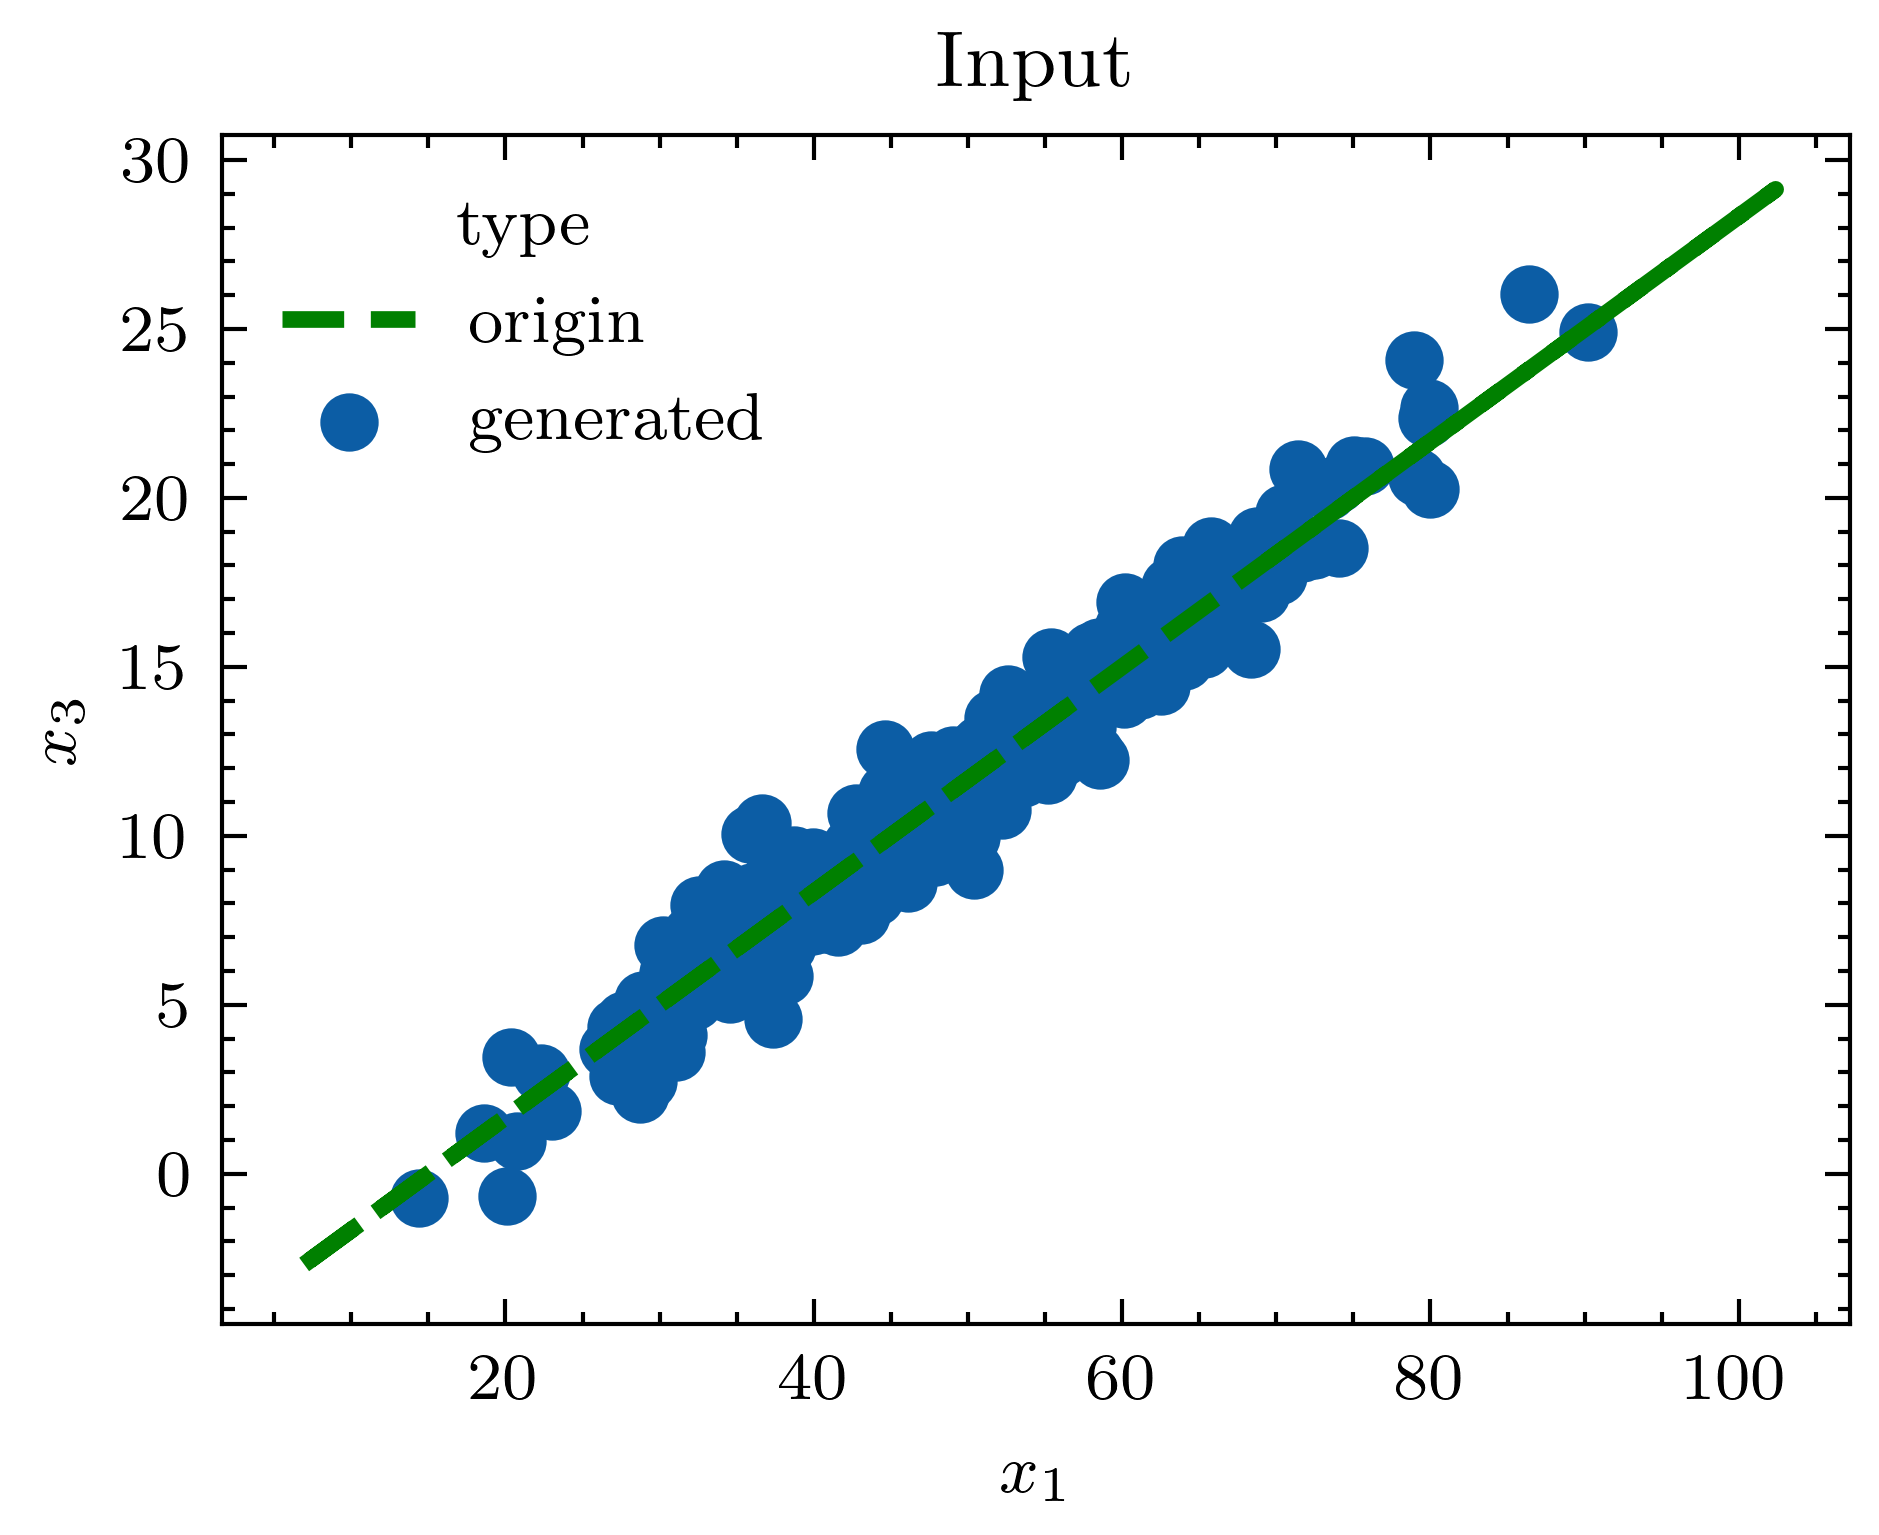

In [ ]:
plot_generated_vs_cf("../results/dummy/VanillaCF_result.pt", "Input", 'x')
distance("../results/dummy/VanillaCF_result.pt", 'x')

{'L1_loss x3': 17.635835647583008,
 'L2_loss x3': 329.1441345214844,
 'L1_loss x4': 16.41033363342285,
 'L2_loss x4': 486.0236511230469}

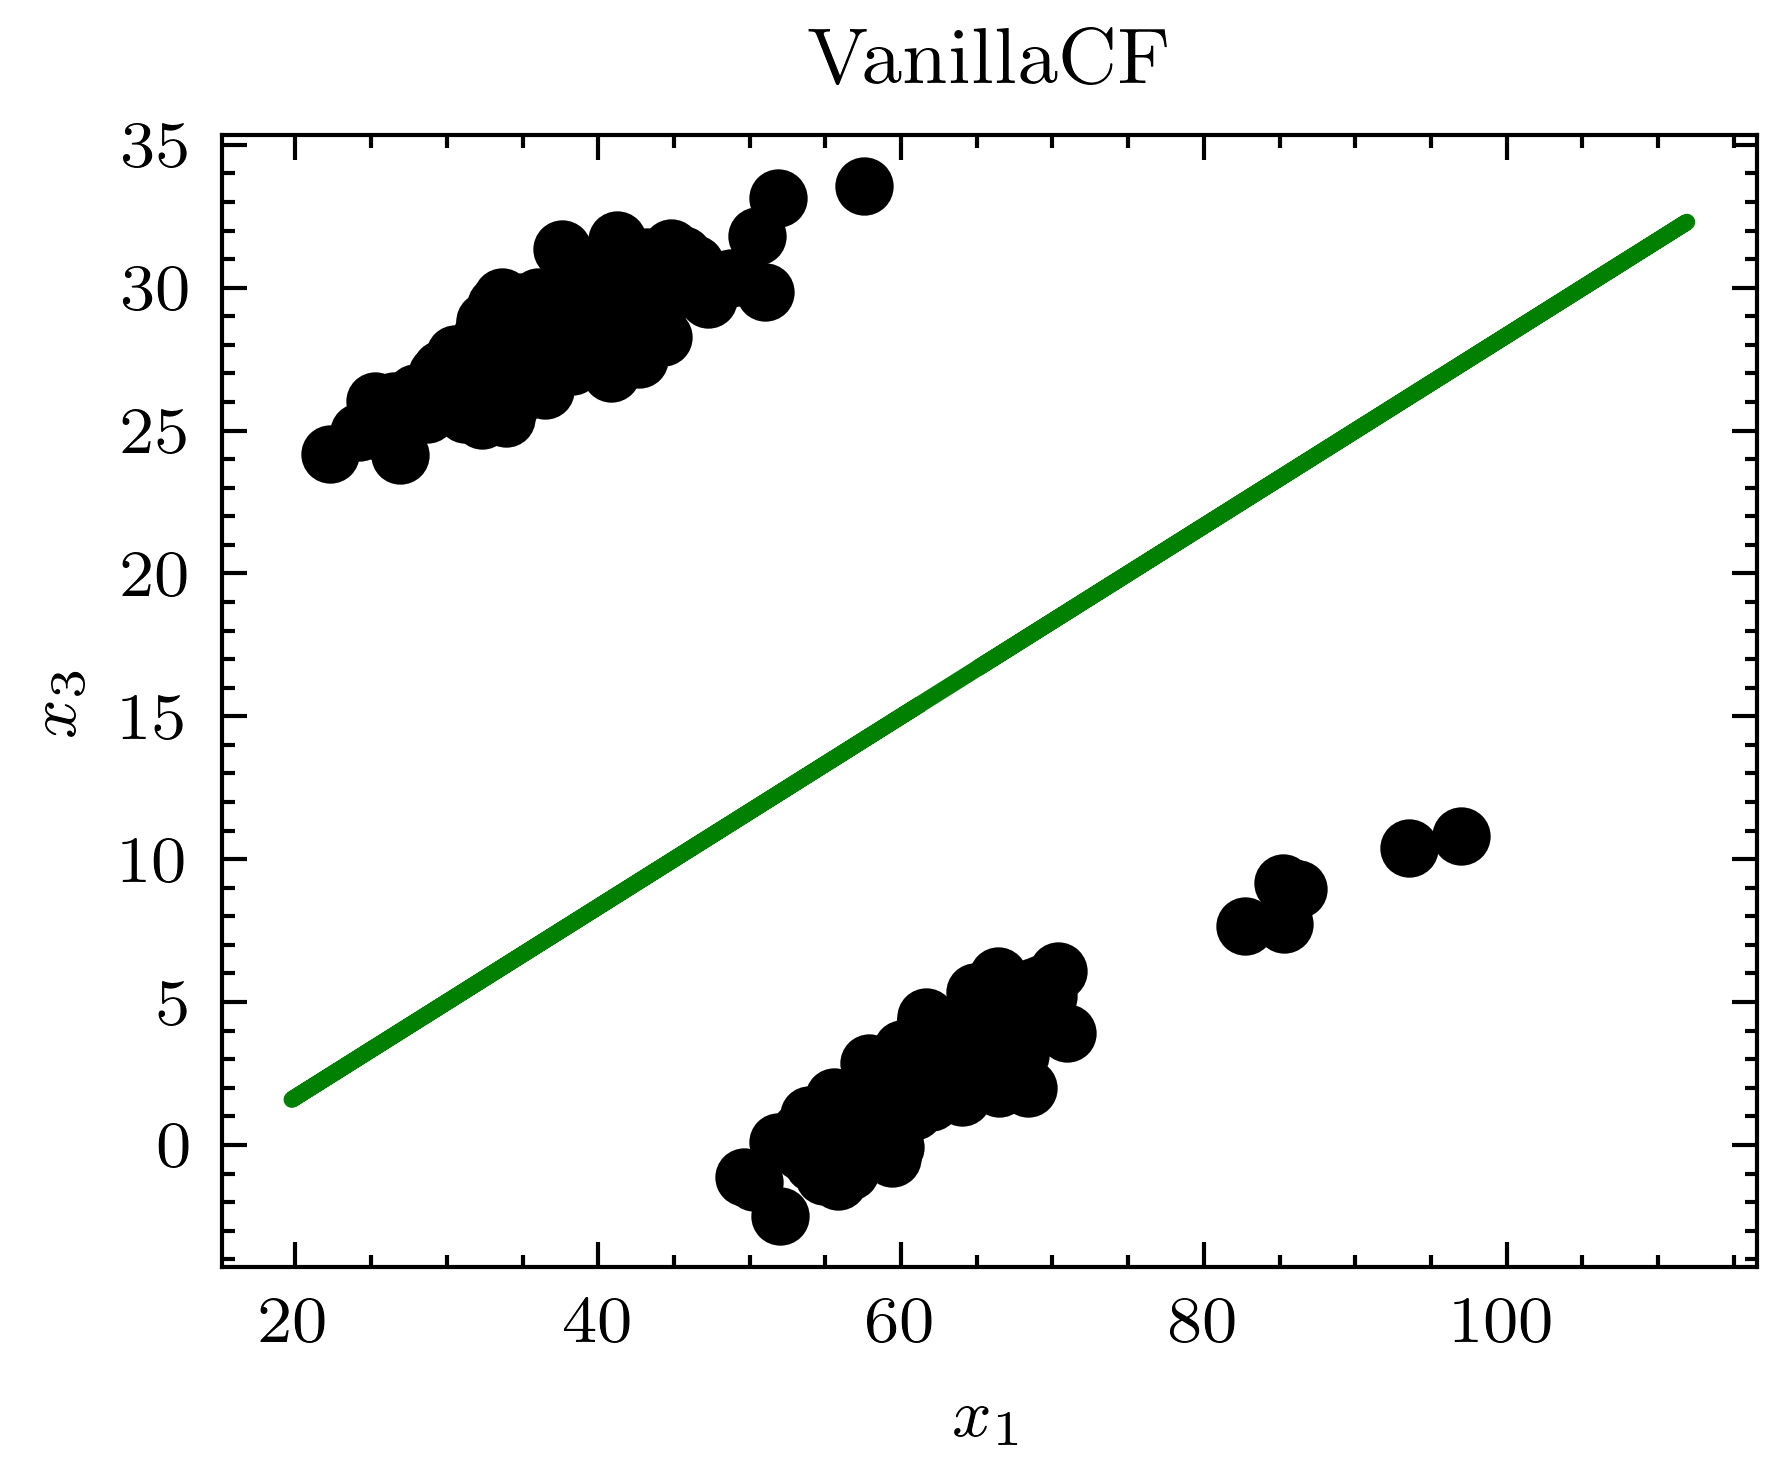

In [ ]:
plot_generated_vs_cf("../results/dummy/VanillaCF_result.pt", "VanillaCF")
distance("../results/dummy/VanillaCF_result.pt")

{'L1_loss x3': 5.740715026855469,
 'L2_loss x3': 56.24019241333008,
 'L1_loss x4': 10.052088737487793,
 'L2_loss x4': 504.3912048339844}

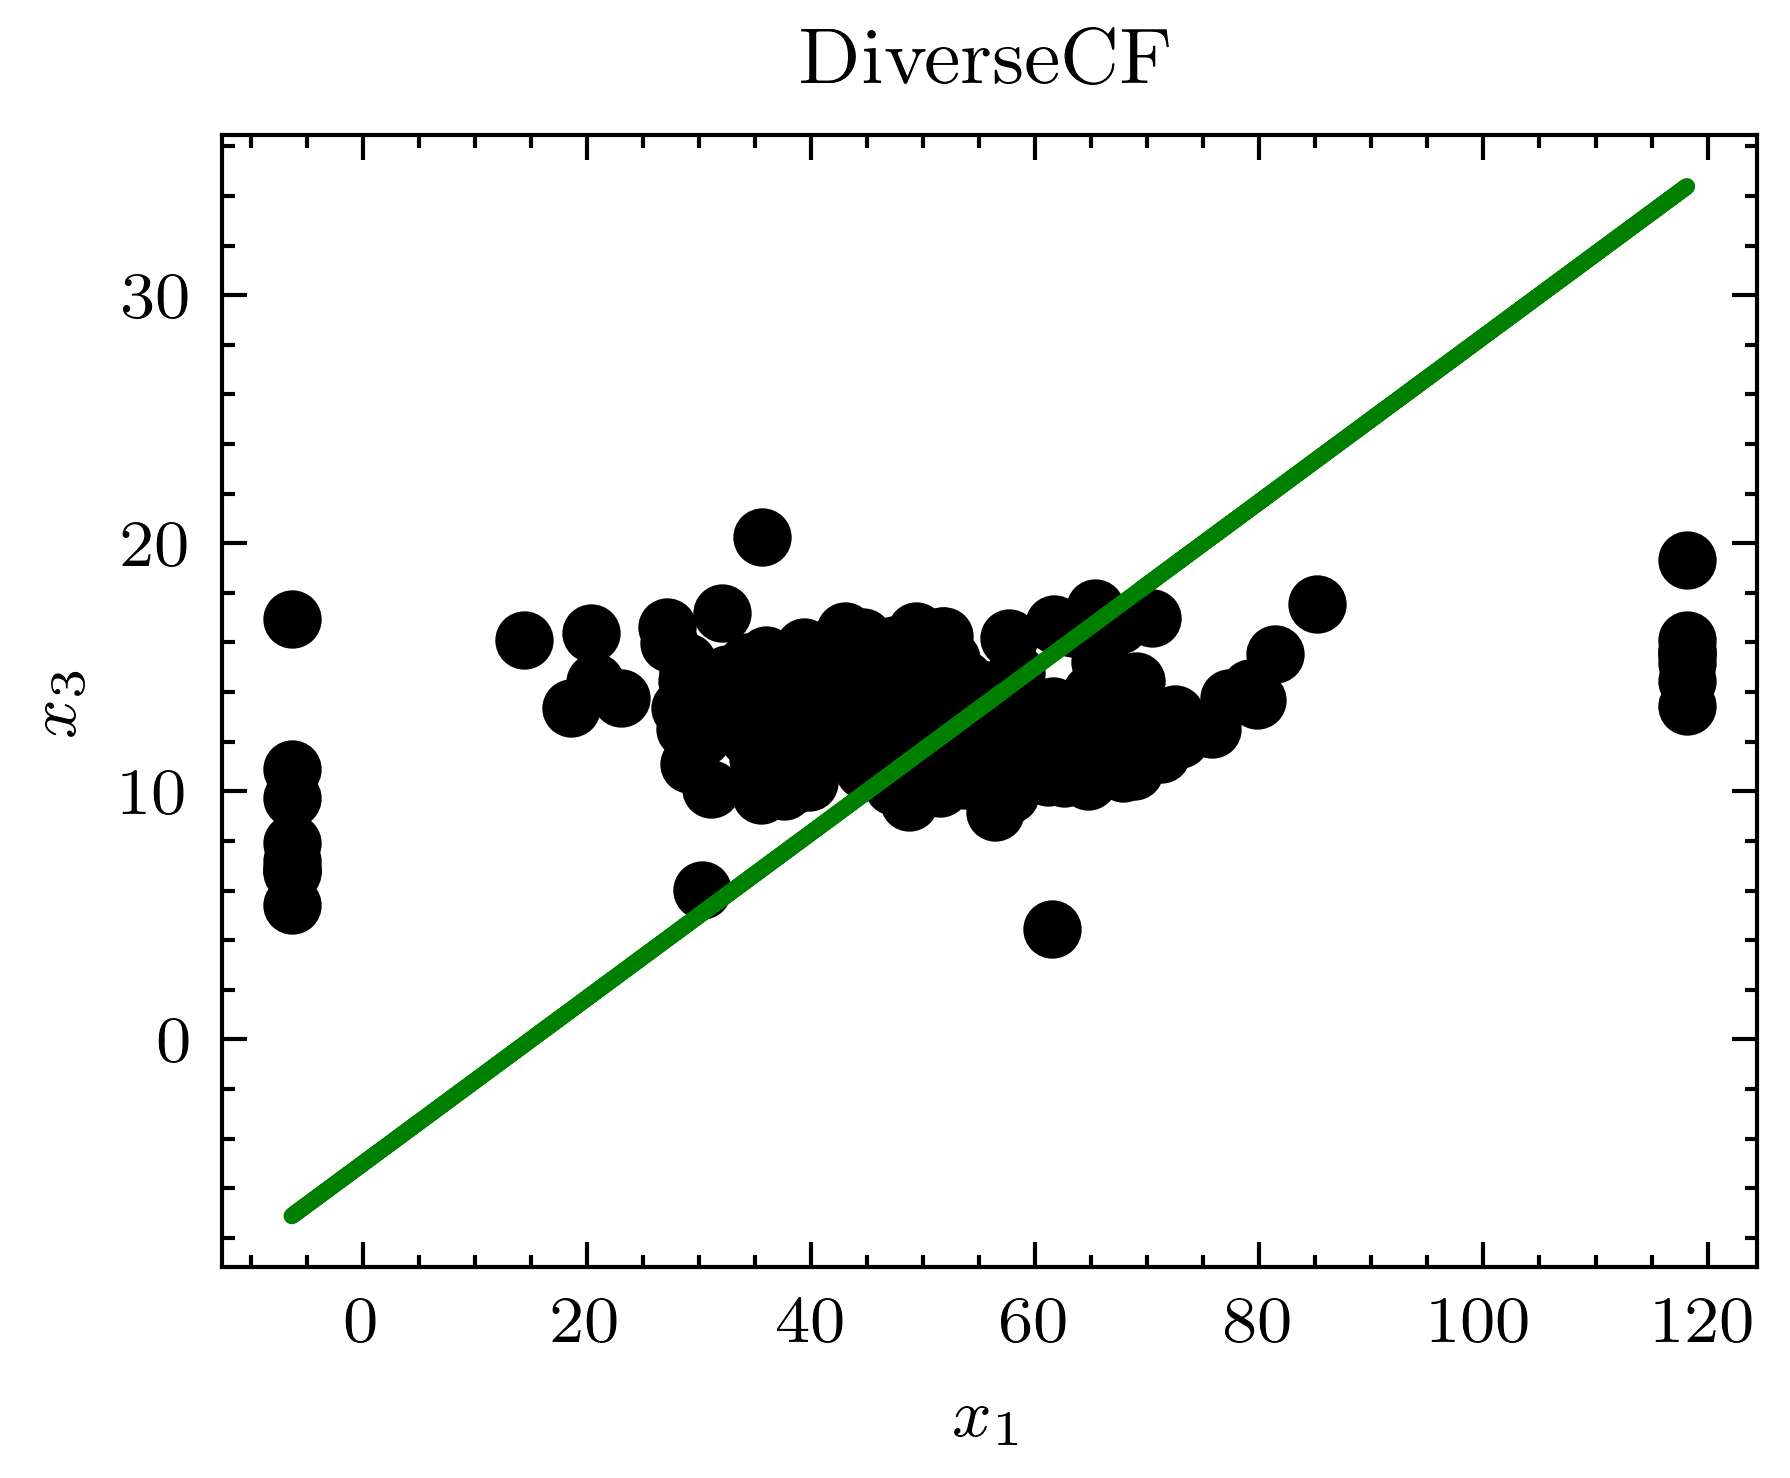

In [ ]:
plot_generated_vs_cf("../results/dummy/DiverseCF_result.pt", "DiverseCF")
distance("../results/dummy/DiverseCF_result.pt")

{'L1_loss x3': 11.477434158325195,
 'L2_loss x3': 158.33767700195312,
 'L1_loss x4': 10.770833015441895,
 'L2_loss x4': 206.90664672851562}

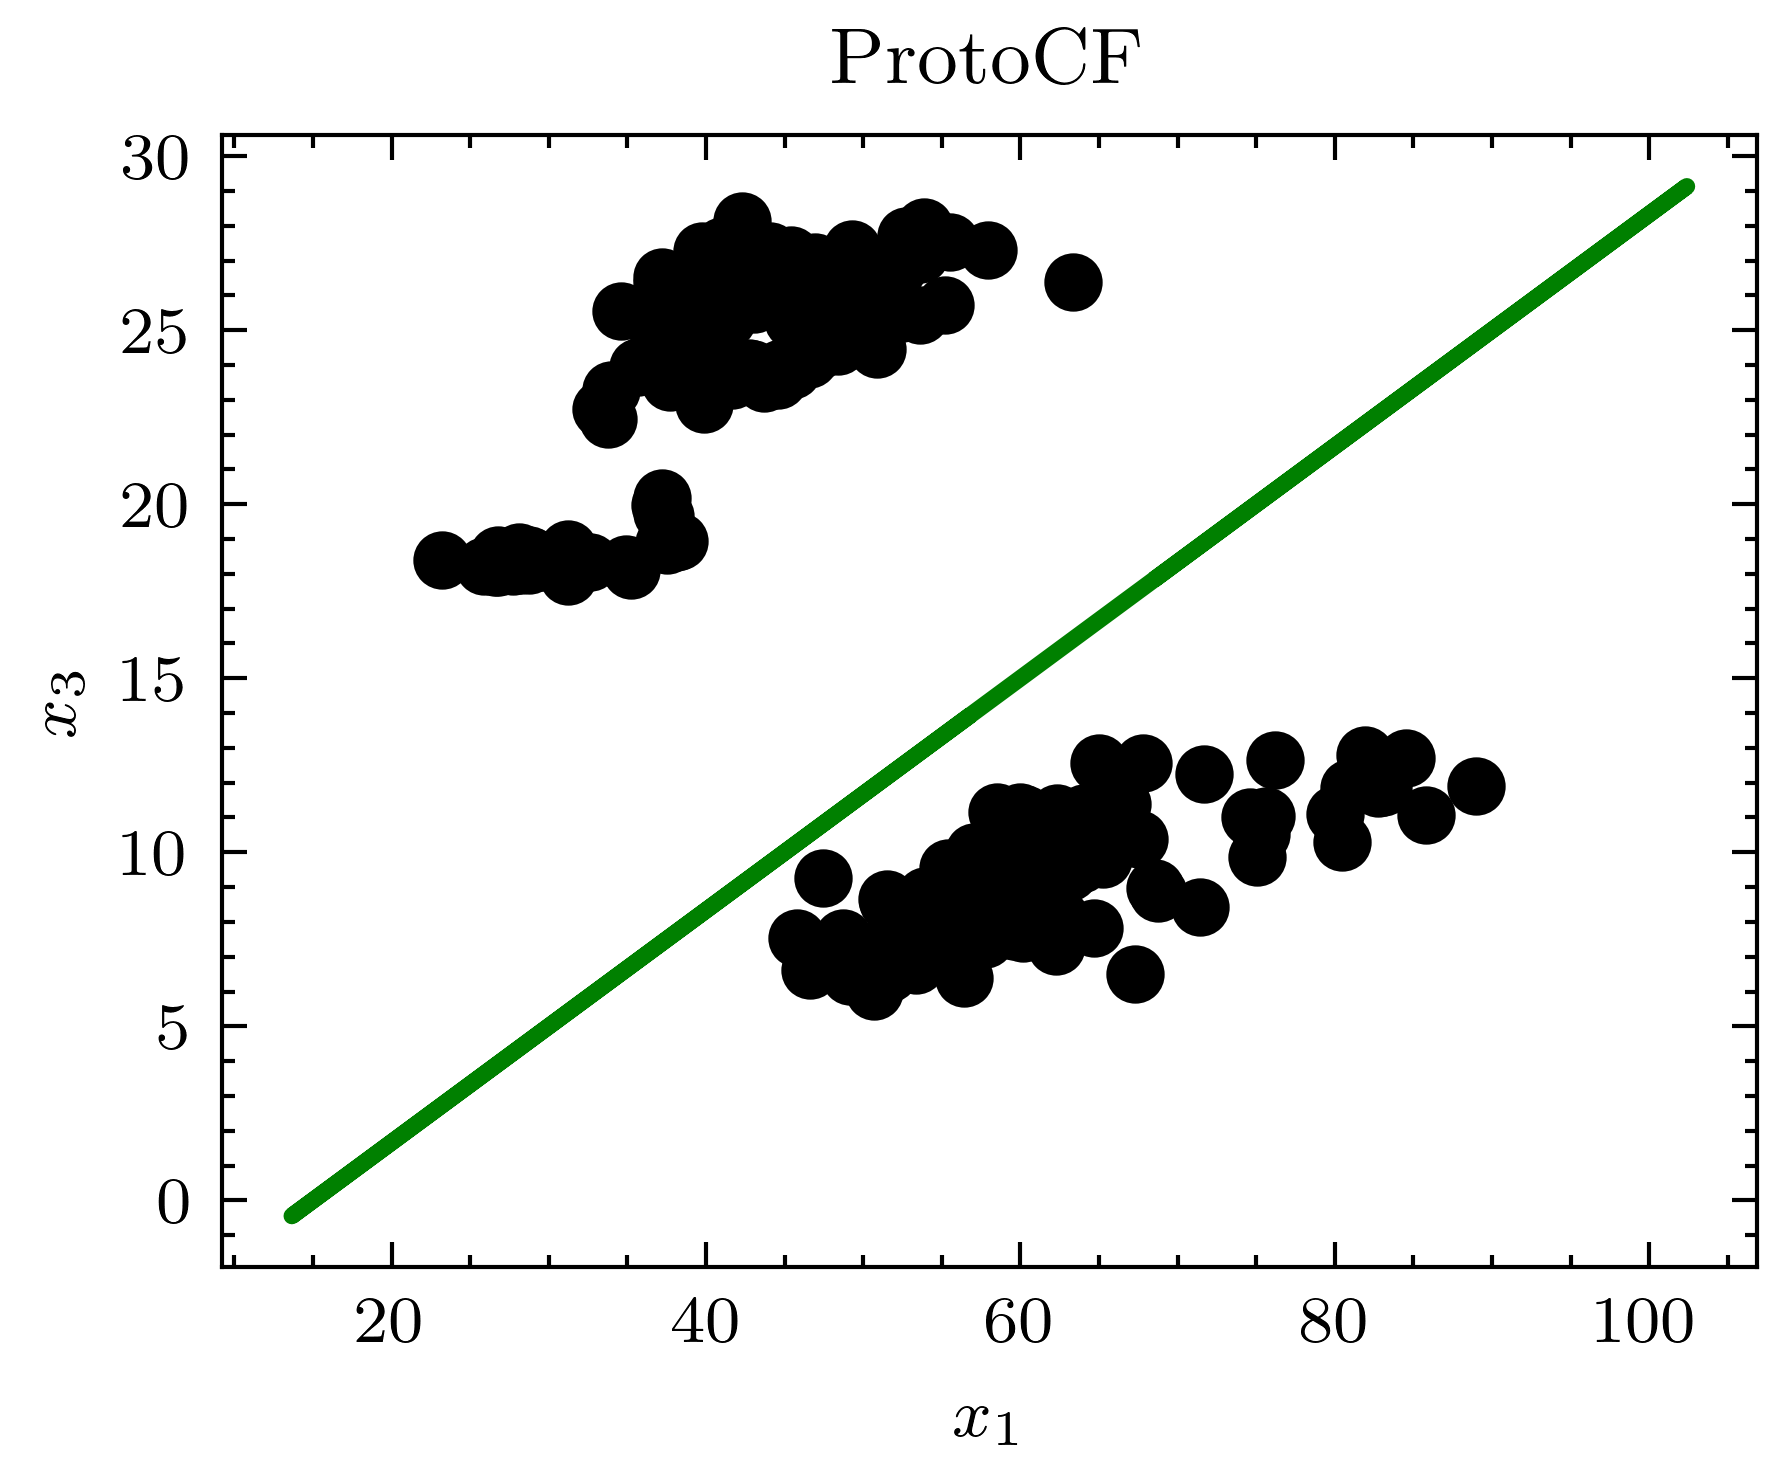

In [ ]:
plot_generated_vs_cf("../results/dummy/ProtoCF_result.pt", "ProtoCF")
distance("../results/dummy/ProtoCF_result.pt")

{'L1_loss x3': 10.277453422546387,
 'L2_loss x3': 126.2057876586914,
 'L1_loss x4': 7.1130499839782715,
 'L2_loss x4': 94.96961975097656}

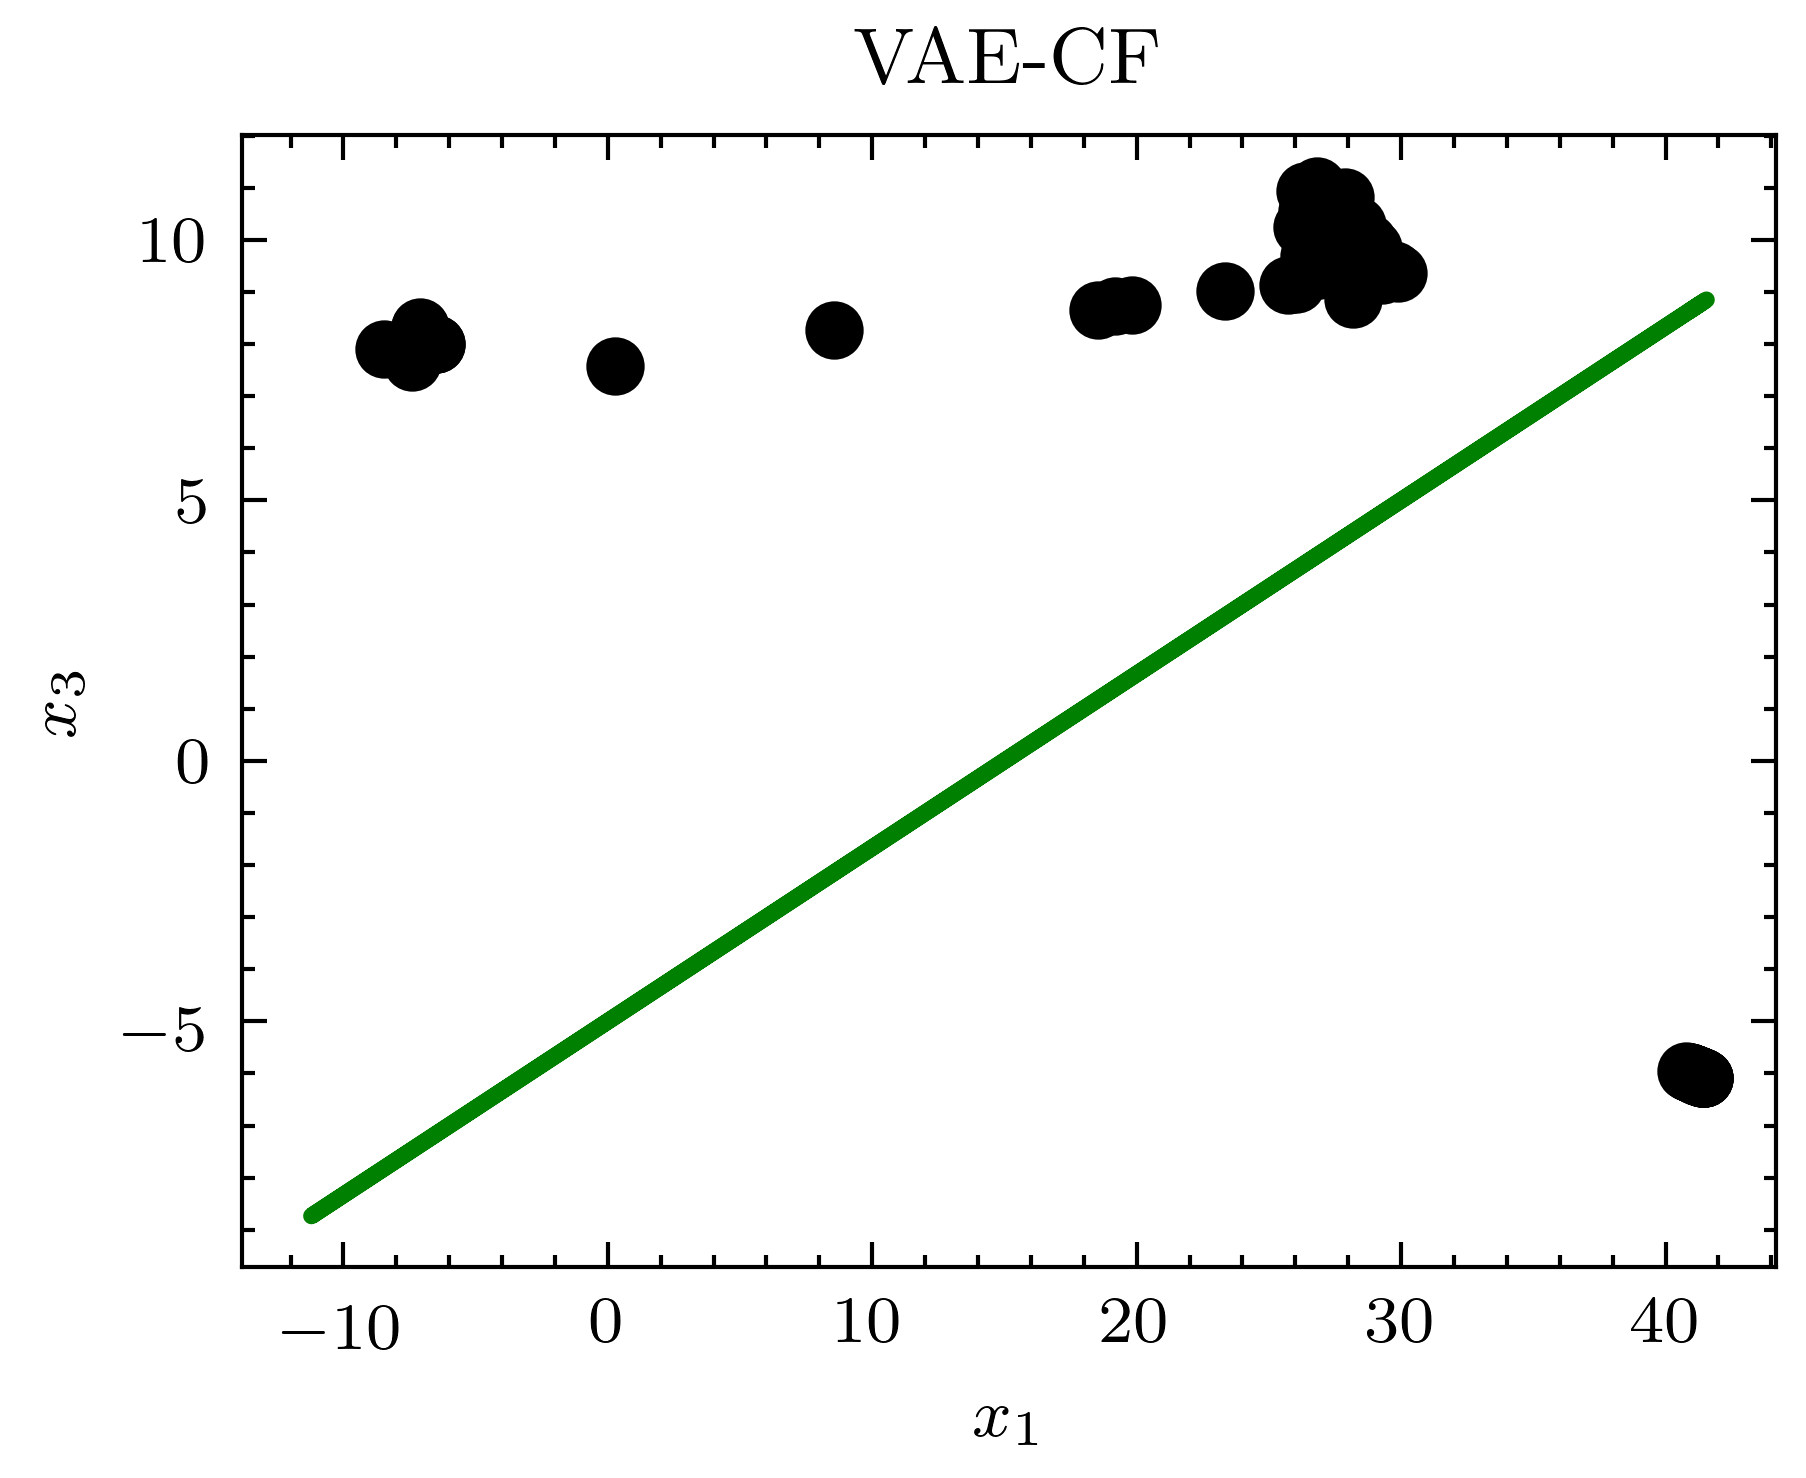

In [ ]:
plot_generated_vs_cf("../results/dummy/VAE-CF_result.pt", "VAE-CF")
distance("../results/dummy/VAE-CF_result.pt")

{'L1_loss x3': 8.630511283874512,
 'L2_loss x3': 83.06946563720703,
 'L1_loss x4': 8.84913158416748,
 'L2_loss x4': 88.26590728759766}

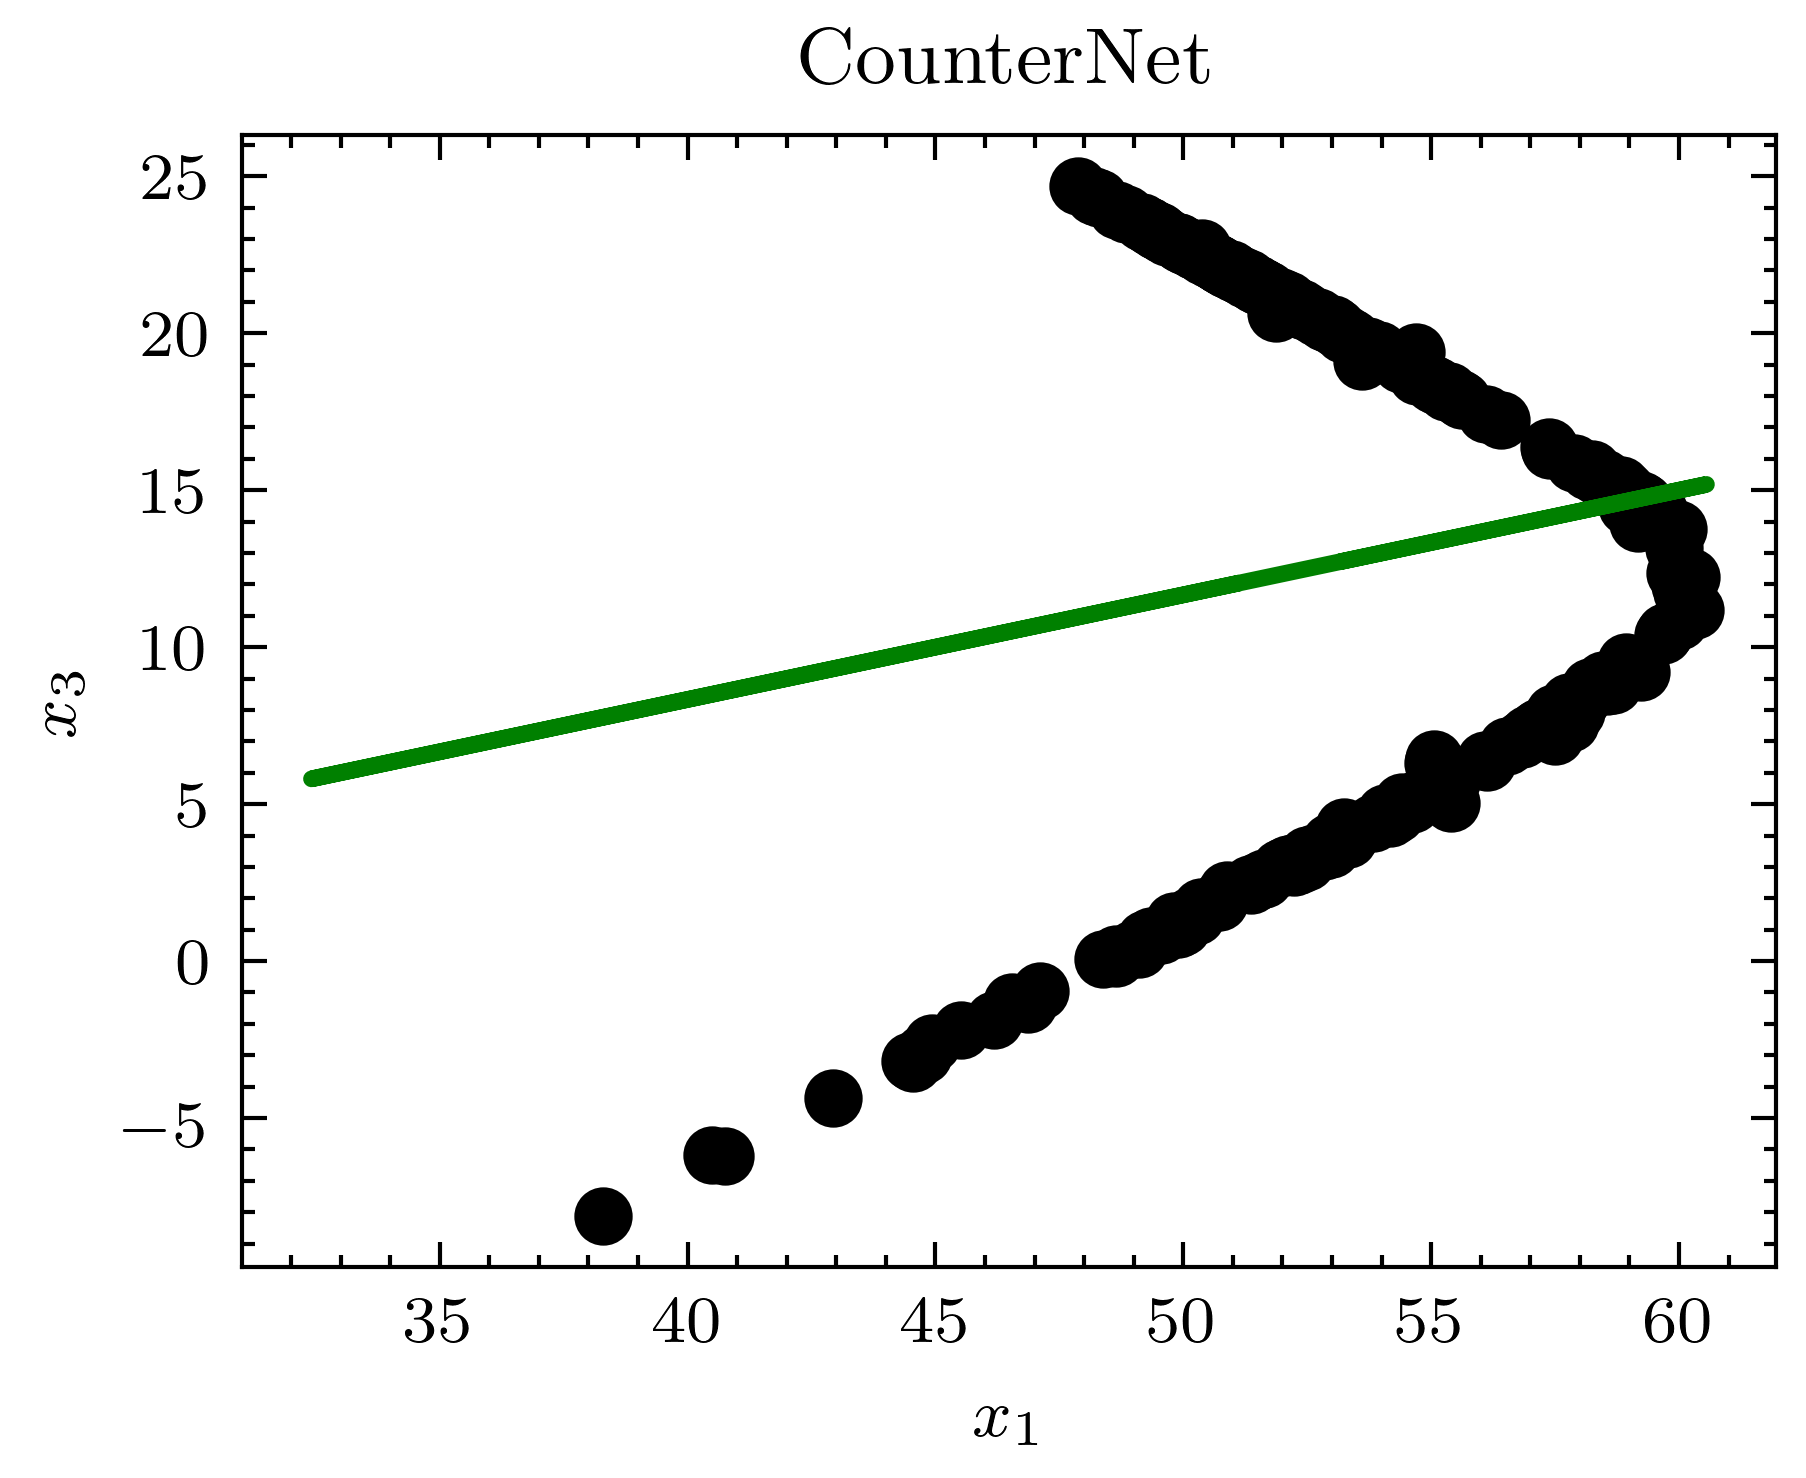

In [ ]:
plot_generated_vs_cf("../results/dummy/CounterfactualNet_result.pt", "CounterNet")
distance("../results/dummy/CounterfactualNet_result.pt", )

# Present CFs

In [ ]:
counter_net = load_model("../saved_weights/adult/c_net/epoch=243-step=46603.ckpt", 244, CounterfactualModel2Optimizers)
counter_net.freeze()
x, y = counter_net.val_dataset[:]

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 2.1 K  | [1, 29]  | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 2.1 K  | [1, 10]  | [1, 29]  
------------------------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params


Training: 0it [00:00, ?it/s]


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
x

tensor([[0.3425, 0.3980, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.5205, 0.3469, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.4795, 0.4490, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
        ...,
        [0.0548, 0.0918, 1.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.0959, 0.3980, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.3973, 0.3980, 0.0000,  ..., 1.0000, 1.0000, 0.0000]])

In [ ]:
results = counter_net.transformed_cf_results(x, y)

In [ ]:
import heapq

# sorted(k)
keys = heapq.nsmallest(20, results)

In [ ]:
for key in keys:
    print(results[key][0])

x_cont: [[46.00000033 50.        ]], x_cat: [['Private' 'Assoc' 'Married' 'Sales' 'White' 'Male']], y_hat: 0.4926919639110565
c_cont: [[16.34859179 45.71300352]], c_cat: [['Private' 'Assoc' 'Married' 'Sales' 'White' 'Male']], c_y: 0.0
x_cont: [[35.99999931 60.00000107]], x_cat: [['Private' 'Some-college' 'Married' 'White-Collar' 'White' 'Male']], y_hat: 0.5342072248458862
c_cont: [[13.11460713 44.29161   ]], c_cat: [['Private' 'Some-college' 'Married' 'White-Collar' 'White' 'Male']], c_y: 0.0
x_cont: [[48.99999976 98.00000048]], x_cat: [['Self-Employed' 'HS-grad' 'Married' 'Blue-Collar' 'White' 'Male']], y_hat: 0.4883488714694977
c_cont: [[16.81637336 45.7203927 ]], c_cat: [['Self-Employed' 'HS-grad' 'Married' 'Blue-Collar' 'White' 'Male']], c_y: 0.0
x_cont: [[84.00000113 19.9999997 ]], x_cat: [['Self-Employed' 'Bachelors' 'Married' 'Blue-Collar' 'White' 'Male']], y_hat: 0.4965519607067108
c_cont: [[15.92650492 45.36394763]], c_cat: [['Self-Employed' 'Bachelors' 'Married' 'Blue-Collar'

# Ablation Analysis

In [ ]:
adult_configs = [
    {"name": "CounterNet", "path": "../saved_weights/adult/c_net/metrics.csv"},
    {"name": "CounterNet-BCE", "path": "../saved_weights/adult/ablation/BCE-metrics.csv"},
    {"name": "CounterNet-SingleBP", "path": "../saved_weights/adult/ablation/single-BP-metrics.csv"},
    {"name": "CounterNet-NoSmooth", "path": "../saved_weights/adult/ablation/no-smooth-metrics.csv"},
]

In [ ]:
home_configs = [
    {"name": "CounterNet", "path": "../saved_weights/home/c_net/metrics.csv"},
    {"name": "CounterNet-BCE", "path": "../saved_weights/home/ablation/BCE-metrics.csv"},
    {"name": "CounterNet-SingleBP", "path": "../saved_weights/home/ablation/single-BP-metrics.csv"},
    {"name": "CounterNet-NoSmooth", "path": "../saved_weights/home/ablation/no-smooth-metrics.csv"},
]

In [ ]:
student_configs = [
    {"name": "CounterNet", "path": "../saved_weights/student/c_net/metrics.csv"},    
    {"name": "CounterNet-BCE", "path": "../saved_weights/student/ablation/BCE-metrics.csv"},
    {"name": "CounterNet-SingleBP", "path": "../saved_weights/student/ablation/single-BP-metrics.csv"},
    {"name": "CounterNet-NoSmooth", "path": "../saved_weights/student/ablation/no-smooth-metrics.csv"},
]

In [ ]:
def ablation_plot(configs, metric_name: str = 'val/cf_accuracy', yaxis_name='validity', fig_name=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    metric_names = ['val/pred_accuracy', 'val/cf_accuracy', 'val/cf_proximity']
#     names = ['Validity $\mathcal{L}_2$', 'Predictive Accuracy $\mathcal{L}_1$', 'Proximity $\mathcal{L}_3$']
    names = ['Predictive Accuracy ($\mathcal{L}_1$)', 'Validity ($\mathcal{L}_2$)', 'Proximity ($\mathcal{L}_3$)']
    
    for i in range(3):
        for config in configs:
            metric = pd.read_csv(config['path'])
            metric = metric[[metric_names[i], 'epoch']].dropna()
            metric = metric[:800][::4]
            axs[i].plot(metric['epoch'].to_numpy(), metric[metric_names[i]].to_numpy(), label=config['name'])
        axs[i].legend(title='Name', fontsize=6, frameon=True)
        axs[i].autoscale(tight=True)
        axs[i].set_title(names[i])
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(names[i])
    
    if fig_name is not None:
        fig.savefig(f"../results/{fig_name}.png", dpi=300, transparent=False, bbox_inches='tight')
        fig.savefig(f"../results/{fig_name}.pdf", transparent=False, bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


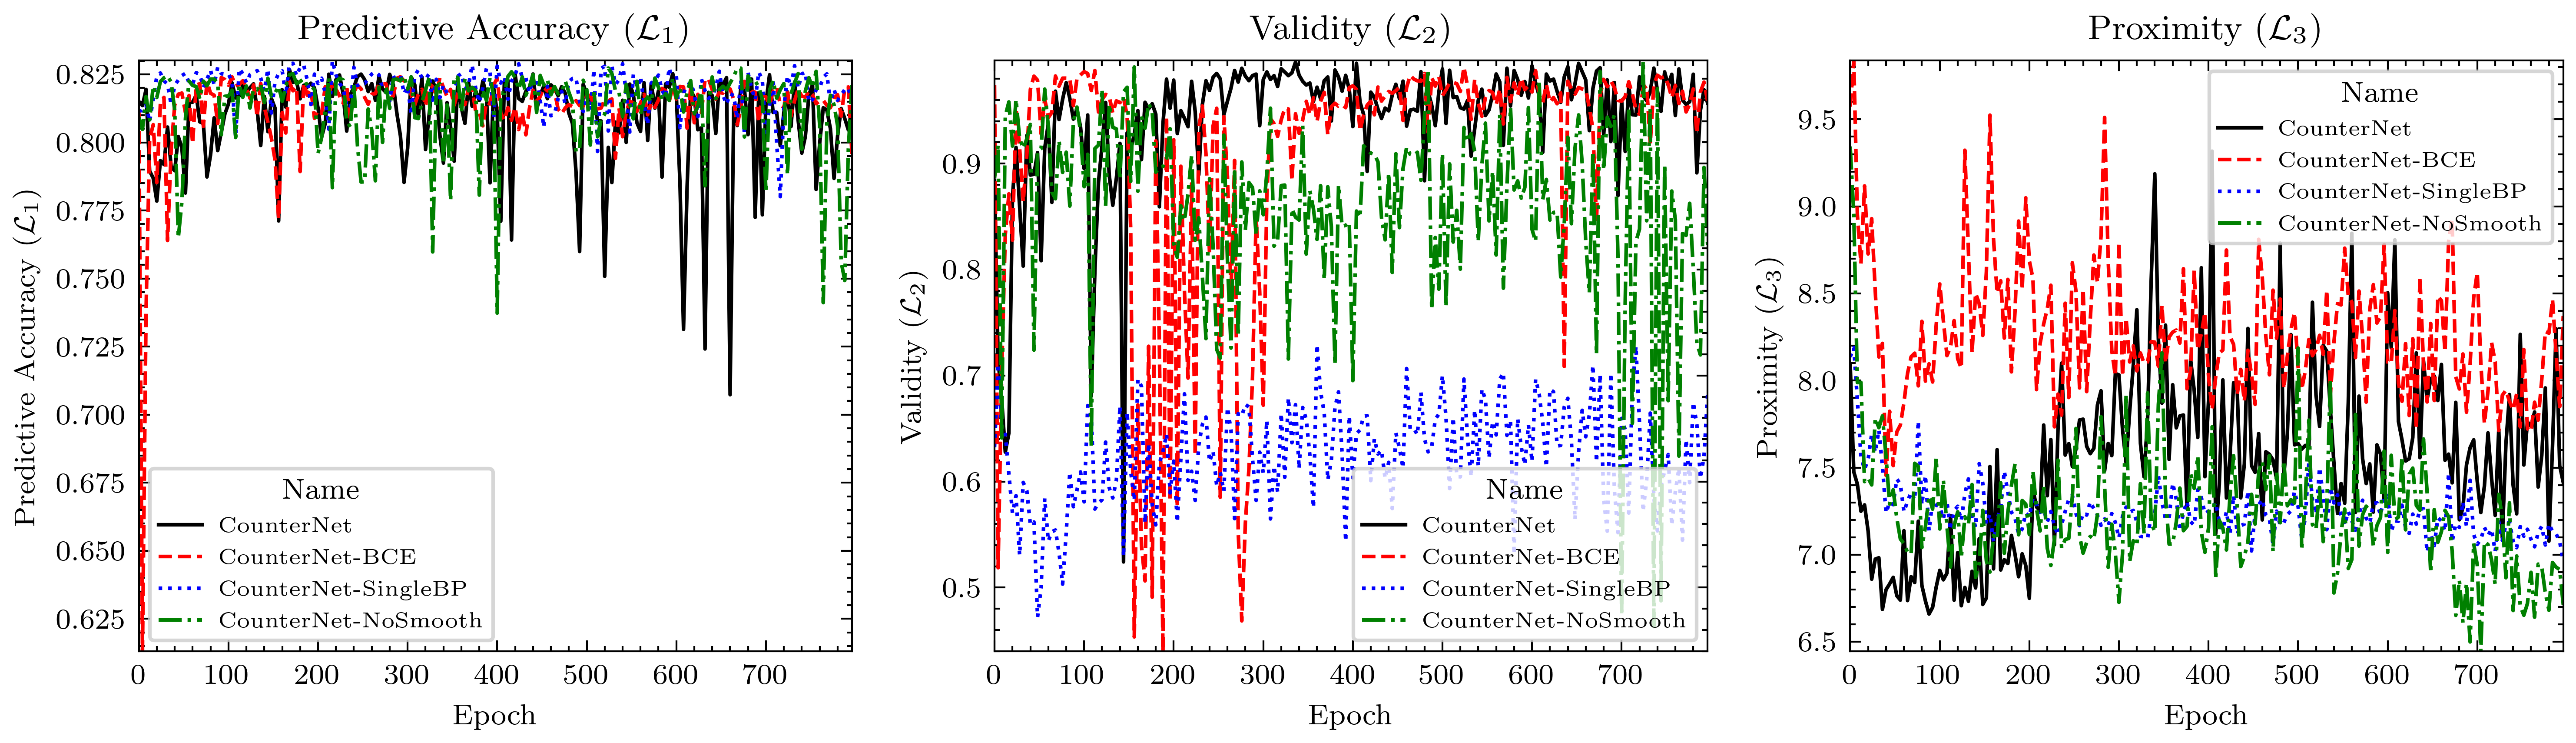

In [ ]:
ablation_plot(adult_configs)

In [ ]:
ablation_plot(home_configs)

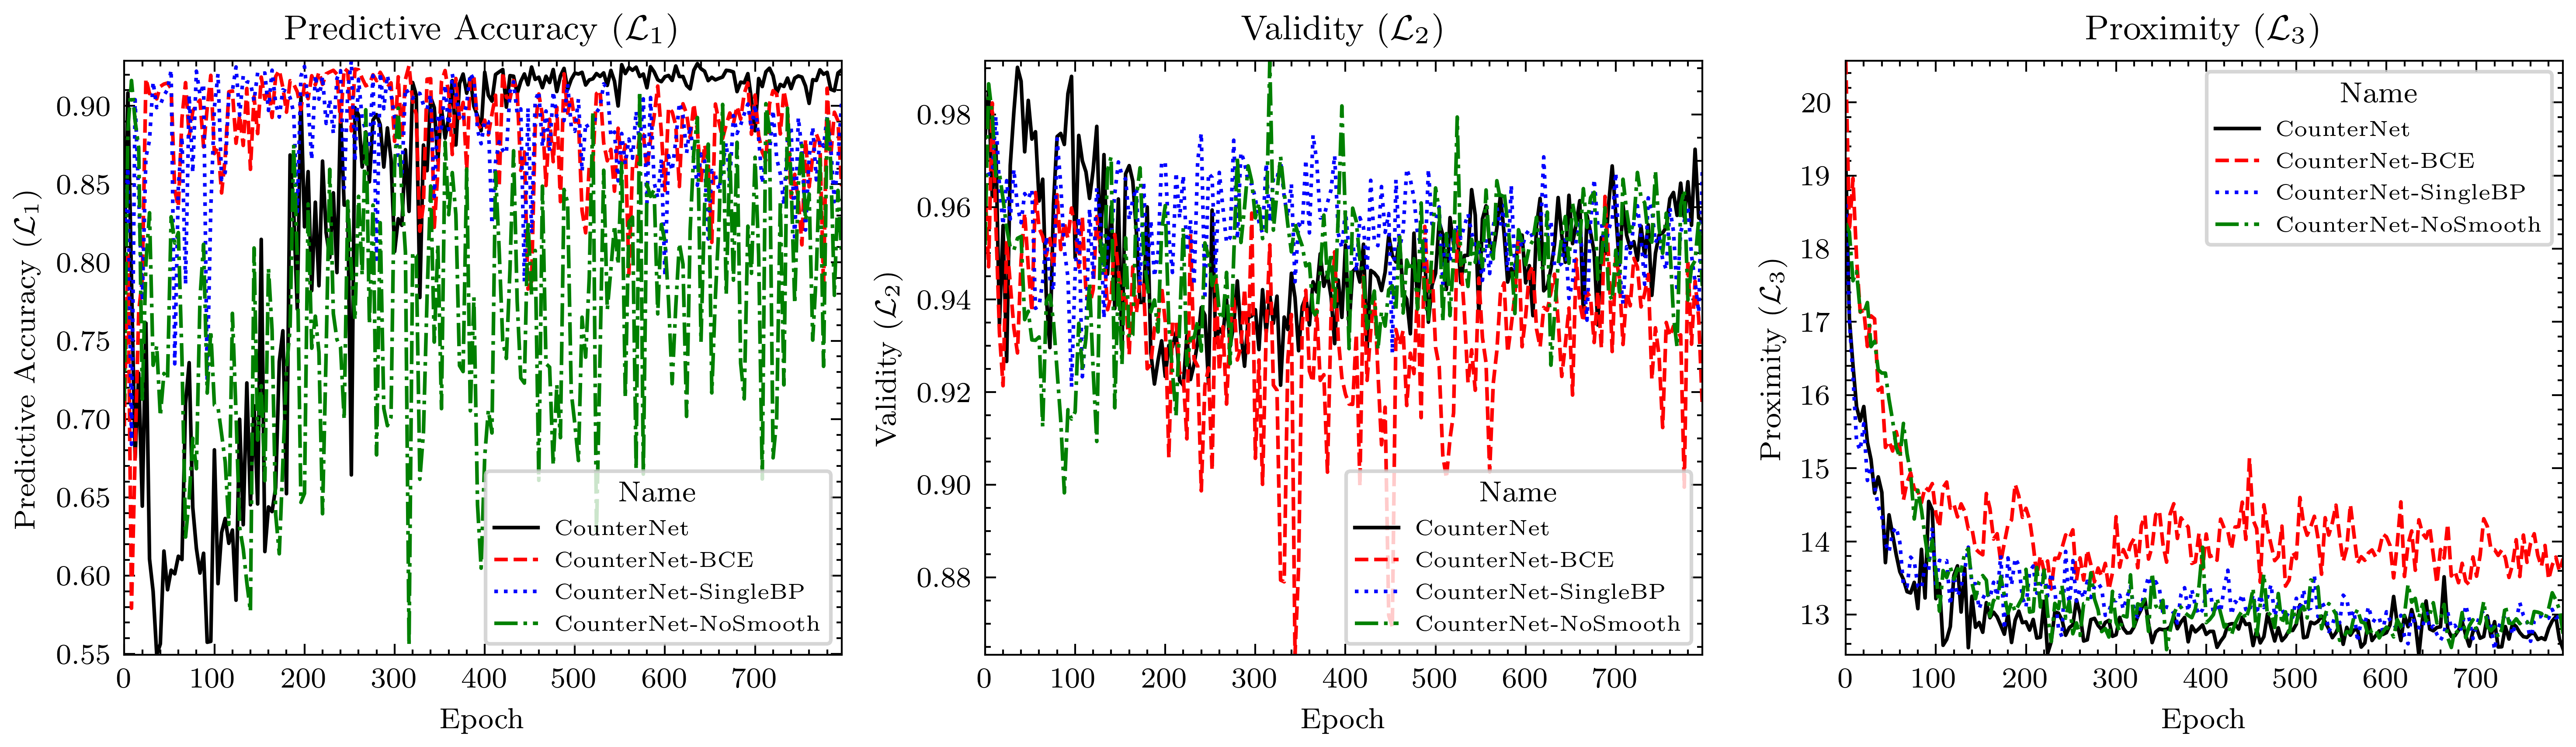

In [ ]:
ablation_plot(student_configs)

# Load Models

In [ ]:
def feature_importance(cat_idx, cat_cols, importances):
    new_importance = [] * (cat_idx + len(cat_cols))
    new_importance = importance[:cat_idx]
    for col in cat_cols:
        cat_idx_end = cat_idx + len(col)
        new_importance[cat_idx]

In [ ]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
#     for i in range(len(feature_names)):
#         print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

## Analysis of Adult Dataset

In [ ]:
# !cd ..
baseline_model = load_model("../saved_weights/adult/baseline/epoch=55-step=10695.ckpt", 56)
c_net = load_model("../saved_weights/adult/c_net/epoch=243-step=46603.ckpt", 244, module=CounterfactualModel2Optimizers)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 2.3 K  | [1, 29]  | [1, 1]   
------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params


Training: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (32561, 2), x_cat: (32561, 27)
(32561, 29)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 2.1 K  | [1, 29]  | [1, 10]  
1 | predictor     | Sequential           | 141    | [1, 10]  | [1, 1]   
2 | explainer     | Sequential           | 2.1 K  | [1, 10]  | [1, 29]  
---------------------------


Training: 0it [00:00, ?it/s]


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
train_dataset = baseline_model.train_dataset
train_X, train_y = train_dataset[:]
val_dataset = baseline_model.val_dataset
test_X, test_y = val_dataset[:]


In [ ]:
def f(x):
    y, c = c_net(x)
    return y

In [ ]:
%%time
# shap = GradientShap(baseline_model)
# shap_attr_test_baseline = shap.attribute(test_X, train_X).detach().numpy().sum(0)
shap = GradientShap(f)
shap_attr_test_c_net = shap.attribute(test_X, train_X).detach().numpy().sum(0)


CPU times: user 4.86 s, sys: 3.36 ms, total: 4.86 s
Wall time: 4.7 s


Average Feature Importances


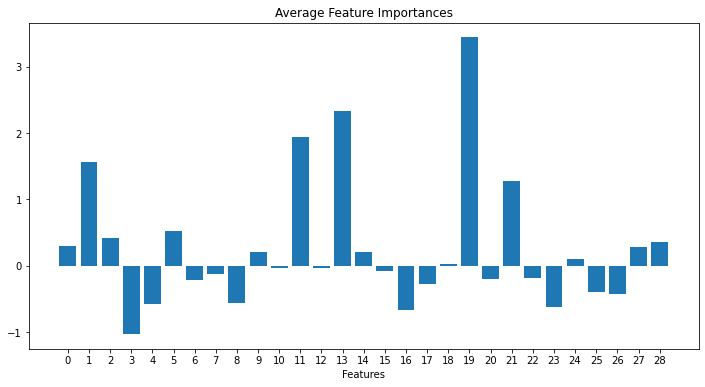

In [ ]:
visualize_importances(range(test_X.size(-1)), shap_attr_test_baseline)

In [ ]:
shap_attr_test_c_net

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Average Feature Importances


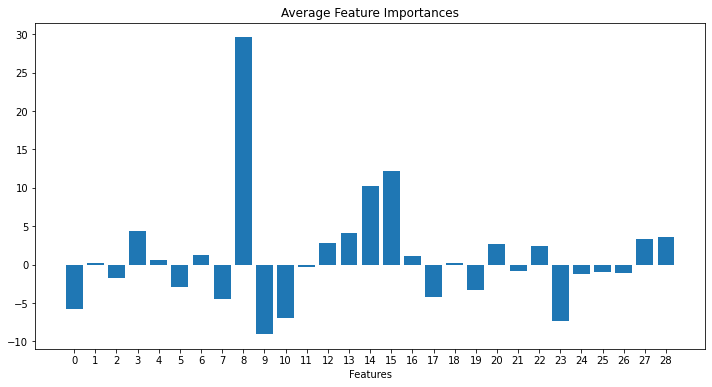

In [ ]:
visualize_importances(range(test_X.size(-1)), shap_attr_test_c_net)

## Analysis of home models

In [ ]:
# !cd ..
baseline_model = load_model("../saved_weights/home/baseline/epoch=92-step=5765.ckpt", 93)
c_net = load_model("../saved_weights/home/c_net/epoch=993-step=61627.ckpt", 994, module=CounterfactualModel2Optimizers)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (10459, 21), x_cat: (10459, 14)
(10459, 35)

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | model | Sequential | 5.0 K  | [1, 35]  | [1, 1]   
------------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params


Training: 0it [00:00, ?it/s]


/opt/conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [ ]:
train_dataset = baseline_model.train_dataset
train_X, train_y = train_dataset[:]
val_dataset = baseline_model.val_dataset
test_X, test_y = val_dataset[:]


In [ ]:
%%time
shap = GradientShap(baseline_model)
shap_attr_test_baseline = gs.attribute(test_X, train_X).detach().numpy().sum(0)
shap = GradientShap(c_net)
shap_attr_test_c_net = gs.attribute(test_X, train_X).detach().numpy().sum(0)


CPU times: user 393 ms, sys: 2.31 ms, total: 395 ms
Wall time: 327 ms


Average Feature Importances


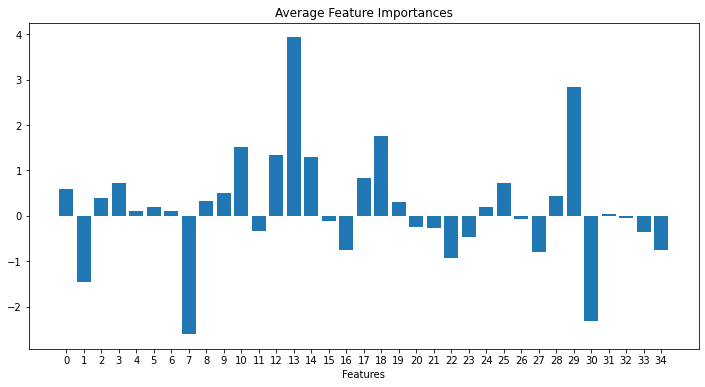

In [ ]:
visualize_importances(range(35), shap_attr_test_baseline)

Average Feature Importances


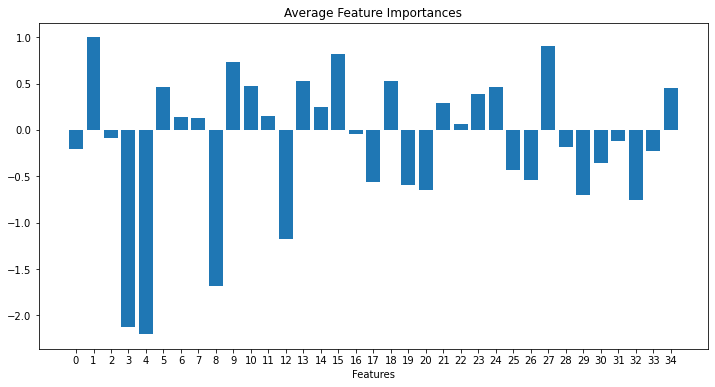

In [ ]:
visualize_importances(range(35), shap_attr_test_c_net)